## Project 3 Part 1

# Garbage/Rubish recognition


### Member 1: Diego Lepe Lozano
### Member 2: Othón Escandón Azpeitia

In the vast space of the Internet there is an idea circulating, which has been partially put into practice. The main idea is to train crows/ravens (and birds of their family) to collect cigarette butts. The idea sounds simple. A container is built for cigarette butts that, upon receipt, delivers some food to the bird as a reward. 

Doing a little more investigation we discovered that something similar is done in certain amusement parks, ravens were trained. The trainer has a wooden box where the raven deposits the cigarette butt and then receives food.The main issue, is that the system is not automated. There are also people who have created kind of "vending machines" in their backyards, that receive bottle caps instead of cigarettes.

In order for the machine to work, we need to recognize that the object the bird brought is valid. Otherwise, they are so smart, they would use pebbles and other items that are not expected to be collected.

With this proposal we seek to expand the amount of objects types that birds can use as "currency" in these vending machines. Being able to identify if it is valid object and classify them appropriately (so we won't mix them in the trash). The objects that will be accepted by our solution are: Drink cans, cigarette butts, plastic straws, metal bottle caps and potato chips bags.

The algorithm will classify objects into their categories and identify if they do not belong to any of them. In order to train the classifier model we will use an already created dataset (or multiple) that could include many other types of garbage. The data will be filter using the accepted ones and "not valid".


The expected results is over 80% of effectiveness.

<br>


## 1. Read Data 

In order to read the data, first we'll separate and group by categories. This will allow us to use multiple datasets, so if we want to expand how many samples are use for certain category we can do it.

All data sets are being used with educational purposes and with no lucrative intention. See all the credits and references in the proper document.

### Taco Trash Dataset

In order to read it we'll use python code, that you can also find as a script in the folder "crop_n_save.py"

The CSV we are using to read this data set is composed with the next columns:<br>
**img_id  img_width  img_height  img_file  cat_id  cat_name  supercategory  ann_id  x  y  width  height  area**

The properties we will be focusing on are:
- **img_id** used to identify the new output
- **ann_id** used to identify the new output
- **img_file** has the path of the image containing the object
- **cat_name** will identify the category the image belongs to
- **x & y** the point where the object section starts (**Roi** Region of Interest)
- **width & height** the with and height of the object section (**Roi**).
    - Will use (x,y), (x + width, y + height) to crop the image

    + ***Note*** that there are some x, y, width and height values that won't be useful (like -1)

Using this properties we can generate a *block* of each category that will live inside this folder and save the cropped image inside that directory
> curated_data/{category_name}/{img_id}\_{ann_id}\_{old_name}.jpg

We won't worry about about the tags csv that annotate the category for each image because that will be a step in the feature. Also we have clustered the images in their respective categories at the moment
   

#### Prep the notebook

Before running all the code we'll prepare some of the environment in the notebook in order to print different visuals and avoid some warnings

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

#### The code
We start importing all we'll be using
- **sys** in order to get the parameters the user can send when running the file as script
- **cv2** used to manipulate the images (crop, save, resize...)
- **re** it helps us to change a path and replace a string using regex
- **csv** can read the csv that has all the information we need to categorize 
- **Path** will be useful to create a dir in case it doesn't exist yet

And we receive the parameters from the command line call if there is any
    

In [2]:
import sys
import cv2
import re
from csv import DictReader
from pathlib import Path

## Getting the arguments passed from bash
# The next to lines will be commented since the notebook does provide arguments. Well use the default path insted
# csv_path = sys.argv[1] if len(sys.argv)>1 else "taco-trash/data.csv" # if there is no path for the csv we use the default one
# curated_path = sys.argv[2] if len(sys.argv)>2 else "eg_curated_data" # if there is no path to save the treated data we use a default one
csv_path = "datasets/taco-trash/data.csv"
curated_path = "curated_data"


Create the function that will crop the Roi and then save the image in the proper directory where that category will be clustered meanwhile

The functions receives as arguments:
- **path** where the image containing the object is
- **x, y, width, height** used to delimit the Roi (values are in `str` we need to change them to `float` then `int`)
- **save2path** where the image will be saved (it includes the file name)


In [3]:

## Will crop the image in the section the object to classify is and then save it to the selected path
def cropNsave(path,x,y,width,height,save2path):
    x = int(float(x))
    y = int(float(y))
    x_end = int(float(width))+x
    y_end = int(float(height))+y

    ## If the values to crop don't make sense will skip saving that image
    if x < 0 or y < 0 or x_end < 0 or y_end < 0:
        return

    ## Open and crop the image in the roi
    img = cv2.imread(path)
    crop = img[y:y_end,x:x_end]

    ## If we are able to save the image we'll notigy the user what image was cropped and where it was saved
    if cv2.imwrite(save2path, crop):
        print("Image ", path, "saved in ", save2path)
    else:         
        sys.stdout.flush()
        print("Image ", path, "couldn't be saved in ", save2path)



#### Execute the function through the csv file

In order to iterate the through the csv file the first step is to open it 
   + **Remember** each time we open a new file we need to close it ( "_with_" can take care of it for us)

Once opened we can read the file with the **csv.DictReader** we already imported. This will give us a list of the rows in the csv, each element (row) of the list will be accesible and we can use keys as in a dictionary to access the columns.

In [4]:

## Open and read the csv that has the images and the section of the image where the object is
file_handle = open(csv_path, "r", encoding="utf8")
csv_reader=DictReader(file_handle)

## Iterate all the data rows in order to classify them according to the tags we have
for row in csv_reader:
    img_id, ann_id, path, x, y, width, height=  row['img_id'],row['ann_id'],row['img_file'],row['x'],row['y'], row['width'], row['height']
    cat_name = row['cat_name'].lower()
    if cat_name == "drink can":
        Path(f"{curated_path}/drink_can").mkdir(parents=True, exist_ok=True)
        save2path = f"{curated_path}/drink_can/" +img_id+ "_"+ann_id+ "_" + re.sub(r'batch_\d+/', '', path)
    elif cat_name == "cigarette":
        Path(f"{curated_path}/cigarette").mkdir(parents=True, exist_ok=True)
        save2path = f"{curated_path}/cigarette/" +img_id+ "_"+ann_id+ "_" + re.sub(r'batch_\d+/', '', path)
    elif cat_name == "plastic straw":
        Path(f"{curated_path}/plastic_straw").mkdir(parents=True, exist_ok=True)
        save2path = f"{curated_path}/plastic_straw/" +img_id+ "_"+ann_id+ "_" + re.sub(r'batch_\d+/', '', path)
    elif cat_name == "metal bottle cap":
        Path(f"{curated_path}/metal_bottle_cap").mkdir(parents=True, exist_ok=True)
        save2path = f"{curated_path}/metal_bottle_cap/" +img_id+ "_"+ann_id+ "_" + re.sub(r'batch_\d+/', '', path)
    # elif cat_name == "plastic bottle cap":
    #     Path(f"{curated_path}/plastic_bottle_cap").mkdir(parents=True, exist_ok=True)
    #     save2path = f"{curated_path}/plastic_bottle_cap/" +img_id+ "_"+ann_id+ "_" + re.sub(r'batch_\d+/', '', path)
    elif cat_name == "crisp packet":
        Path(f"{curated_path}/crisp_packet").mkdir(parents=True, exist_ok=True)
        save2path = f"{curated_path}/crisp_packet/" +img_id+ "_"+ann_id+ "_" + re.sub(r'batch_\d+/', '', path)
    else : 
        Path(f"{curated_path}/not_valid").mkdir(parents=True, exist_ok=True)
        save2path = f"{curated_path}/not_valid/" +img_id+ "_"+ann_id+ "_" + re.sub(r'batch_\d+/', '', path)

    ## We execute this function that will save the img with the information provided. 
    ## After running this function the image will be saved into a folder and now we now all the images inside
    ##   that folder are the same class/type
    dir_path = csv_path.replace('.csv','') #taco-trash uses the same naming for the dir and the csv so we just delete the extension
    cropNsave(f"{dir_path}/{path}",x,y,width,height,save2path)

## Don't forget to close the file_handle
file_handle.close

Image  datasets/taco-trash/data/batch_1/000006.jpg saved in  curated_data/not_valid/0_1_000006.jpg
Image  datasets/taco-trash/data/batch_1/000008.jpg saved in  curated_data/not_valid/1_2_000008.jpg
Image  datasets/taco-trash/data/batch_1/000008.jpg saved in  curated_data/not_valid/1_3_000008.jpg
Image  datasets/taco-trash/data/batch_1/000010.jpg saved in  curated_data/not_valid/2_4_000010.jpg
Image  datasets/taco-trash/data/batch_1/000010.jpg saved in  curated_data/not_valid/2_5_000010.jpg
Image  datasets/taco-trash/data/batch_1/000019.jpg saved in  curated_data/not_valid/3_6_000019.jpg
Image  datasets/taco-trash/data/batch_1/000019.jpg saved in  curated_data/not_valid/3_7_000019.jpg
Image  datasets/taco-trash/data/batch_1/000019.jpg saved in  curated_data/not_valid/3_8_000019.jpg
Image  datasets/taco-trash/data/batch_1/000019.jpg saved in  curated_data/drink_can/3_9_000019.jpg
Image  datasets/taco-trash/data/batch_1/000026.jpg saved in  curated_data/drink_can/4_10_000026.jpg
Image  da

Image  datasets/taco-trash/data/batch_1/000042.jpg saved in  curated_data/not_valid/33_88_000042.jpg
Image  datasets/taco-trash/data/batch_1/000042.jpg saved in  curated_data/not_valid/33_89_000042.jpg
Image  datasets/taco-trash/data/batch_1/000042.jpg saved in  curated_data/not_valid/33_90_000042.jpg
Image  datasets/taco-trash/data/batch_1/000050.jpg saved in  curated_data/drink_can/34_91_000050.jpg
Image  datasets/taco-trash/data/batch_1/000050.jpg saved in  curated_data/not_valid/34_92_000050.jpg
Image  datasets/taco-trash/data/batch_1/000059.jpg saved in  curated_data/not_valid/35_93_000059.jpg
Image  datasets/taco-trash/data/batch_1/000059.jpg saved in  curated_data/not_valid/35_94_000059.jpg
Image  datasets/taco-trash/data/batch_1/000059.jpg saved in  curated_data/not_valid/35_95_000059.jpg
Image  datasets/taco-trash/data/batch_1/000059.jpg saved in  curated_data/not_valid/35_96_000059.jpg
Image  datasets/taco-trash/data/batch_1/000000.jpg saved in  curated_data/not_valid/36_97_0

Image  datasets/taco-trash/data/batch_1/000085.JPG saved in  curated_data/cigarette/64_297_000085.JPG
Image  datasets/taco-trash/data/batch_1/000085.JPG saved in  curated_data/cigarette/64_298_000085.JPG
Image  datasets/taco-trash/data/batch_1/000085.JPG saved in  curated_data/cigarette/64_299_000085.JPG
Image  datasets/taco-trash/data/batch_1/000085.JPG saved in  curated_data/cigarette/64_300_000085.JPG
Image  datasets/taco-trash/data/batch_1/000086.JPG saved in  curated_data/not_valid/65_156_000086.JPG
Image  datasets/taco-trash/data/batch_1/000086.JPG saved in  curated_data/cigarette/65_301_000086.JPG
Image  datasets/taco-trash/data/batch_1/000086.JPG saved in  curated_data/cigarette/65_302_000086.JPG
Image  datasets/taco-trash/data/batch_1/000087.JPG saved in  curated_data/not_valid/66_157_000087.JPG
Image  datasets/taco-trash/data/batch_1/000087.JPG saved in  curated_data/cigarette/66_303_000087.JPG
Image  datasets/taco-trash/data/batch_1/000088.JPG saved in  curated_data/not_vali

Image  datasets/taco-trash/data/batch_1/000111.JPG saved in  curated_data/drink_can/88_229_000111.JPG
Image  datasets/taco-trash/data/batch_1/000111.JPG saved in  curated_data/not_valid/88_230_000111.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/not_valid/89_231_000115.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/not_valid/89_232_000115.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/not_valid/89_233_000115.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/drink_can/89_234_000115.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/not_valid/89_235_000115.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/not_valid/89_236_000115.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/not_valid/89_237_000115.JPG
Image  datasets/taco-trash/data/batch_1/000115.JPG saved in  curated_data/not_vali

Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_330_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_331_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_332_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_333_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_334_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_335_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_336_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_337_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  curated_data/not_valid/104_338_000003.jpg
Image  datasets/taco-trash/data/batch_10/000003.jpg saved in  cu

Image  datasets/taco-trash/data/batch_10/000020.jpg saved in  curated_data/cigarette/121_413_000020.jpg
Image  datasets/taco-trash/data/batch_10/000020.jpg saved in  curated_data/cigarette/121_414_000020.jpg
Image  datasets/taco-trash/data/batch_10/000020.jpg saved in  curated_data/cigarette/121_415_000020.jpg
Image  datasets/taco-trash/data/batch_10/000021.jpg saved in  curated_data/not_valid/122_416_000021.jpg
Image  datasets/taco-trash/data/batch_10/000021.jpg saved in  curated_data/cigarette/122_417_000021.jpg
Image  datasets/taco-trash/data/batch_10/000021.jpg saved in  curated_data/cigarette/122_418_000021.jpg
Image  datasets/taco-trash/data/batch_10/000021.jpg saved in  curated_data/cigarette/122_419_000021.jpg
Image  datasets/taco-trash/data/batch_10/000021.jpg saved in  curated_data/cigarette/122_420_000021.jpg
Image  datasets/taco-trash/data/batch_10/000021.jpg saved in  curated_data/cigarette/122_421_000021.jpg
Image  datasets/taco-trash/data/batch_10/000021.jpg saved in  cu

Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/cigarette/137_494_000036.jpg
Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/cigarette/137_495_000036.jpg
Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/cigarette/137_496_000036.jpg
Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/cigarette/137_497_000036.jpg
Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/cigarette/137_498_000036.jpg
Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/cigarette/137_499_000036.jpg
Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/not_valid/137_500_000036.jpg
Image  datasets/taco-trash/data/batch_10/000036.jpg saved in  curated_data/not_valid/137_501_000036.jpg
Image  datasets/taco-trash/data/batch_10/000037.jpg saved in  curated_data/not_valid/138_502_000037.jpg
Image  datasets/taco-trash/data/batch_10/000037.jpg saved in  cu

Image  datasets/taco-trash/data/batch_10/000064.jpg saved in  curated_data/cigarette/165_573_000064.jpg
Image  datasets/taco-trash/data/batch_10/000065.jpg saved in  curated_data/not_valid/166_574_000065.jpg
Image  datasets/taco-trash/data/batch_10/000066.jpg saved in  curated_data/not_valid/167_575_000066.jpg
Image  datasets/taco-trash/data/batch_10/000067.jpg saved in  curated_data/not_valid/168_576_000067.jpg
Image  datasets/taco-trash/data/batch_10/000068.jpg saved in  curated_data/not_valid/169_577_000068.jpg
Image  datasets/taco-trash/data/batch_10/000069.jpg saved in  curated_data/not_valid/170_578_000069.jpg
Image  datasets/taco-trash/data/batch_10/000070.jpg saved in  curated_data/not_valid/171_579_000070.jpg
Image  datasets/taco-trash/data/batch_10/000070.jpg saved in  curated_data/not_valid/171_580_000070.jpg
Image  datasets/taco-trash/data/batch_10/000071.jpg saved in  curated_data/not_valid/172_581_000071.jpg
Image  datasets/taco-trash/data/batch_10/000071.jpg saved in  cu

Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_653_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_654_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_655_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_656_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_657_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_658_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_659_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_660_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  curated_data/not_valid/194_661_000093.jpg
Image  datasets/taco-trash/data/batch_10/000093.jpg saved in  cu

Image  datasets/taco-trash/data/batch_11/000018.jpg saved in  curated_data/not_valid/219_734_000018.jpg
Image  datasets/taco-trash/data/batch_11/000018.jpg saved in  curated_data/not_valid/219_735_000018.jpg
Image  datasets/taco-trash/data/batch_11/000018.jpg saved in  curated_data/not_valid/219_736_000018.jpg
Image  datasets/taco-trash/data/batch_11/000018.jpg saved in  curated_data/not_valid/219_737_000018.jpg
Image  datasets/taco-trash/data/batch_11/000018.jpg saved in  curated_data/not_valid/219_738_000018.jpg
Image  datasets/taco-trash/data/batch_11/000018.jpg saved in  curated_data/not_valid/219_739_000018.jpg
Image  datasets/taco-trash/data/batch_11/000018.jpg saved in  curated_data/not_valid/219_740_000018.jpg
Image  datasets/taco-trash/data/batch_11/000019.jpg saved in  curated_data/not_valid/220_741_000019.jpg
Image  datasets/taco-trash/data/batch_11/000019.jpg saved in  curated_data/not_valid/220_742_000019.jpg
Image  datasets/taco-trash/data/batch_11/000019.jpg saved in  cu

Image  datasets/taco-trash/data/batch_11/000060.jpg saved in  curated_data/not_valid/261_813_000060.jpg
Image  datasets/taco-trash/data/batch_11/000061.jpg saved in  curated_data/not_valid/262_814_000061.jpg
Image  datasets/taco-trash/data/batch_11/000061.jpg saved in  curated_data/not_valid/262_815_000061.jpg
Image  datasets/taco-trash/data/batch_11/000062.jpg saved in  curated_data/not_valid/263_816_000062.jpg
Image  datasets/taco-trash/data/batch_11/000063.jpg saved in  curated_data/not_valid/264_817_000063.jpg
Image  datasets/taco-trash/data/batch_11/000063.jpg saved in  curated_data/not_valid/264_818_000063.jpg
Image  datasets/taco-trash/data/batch_11/000063.jpg saved in  curated_data/not_valid/264_819_000063.jpg
Image  datasets/taco-trash/data/batch_11/000063.jpg saved in  curated_data/not_valid/264_820_000063.jpg
Image  datasets/taco-trash/data/batch_11/000063.jpg saved in  curated_data/not_valid/264_821_000063.jpg
Image  datasets/taco-trash/data/batch_11/000064.jpg saved in  cu

Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_893_000095.jpg
Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_894_000095.jpg
Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_895_000095.jpg
Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_896_000095.jpg
Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_897_000095.jpg
Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_898_000095.jpg
Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_899_000095.jpg
Image  datasets/taco-trash/data/batch_11/000095.jpg saved in  curated_data/not_valid/296_900_000095.jpg
Image  datasets/taco-trash/data/batch_11/000096.jpg saved in  curated_data/not_valid/297_901_000096.jpg
Image  datasets/taco-trash/data/batch_11/000096.jpg saved in  cu

Image  datasets/taco-trash/data/batch_12/000022.jpg saved in  curated_data/not_valid/323_972_000022.jpg
Image  datasets/taco-trash/data/batch_12/000023.jpg saved in  curated_data/drink_can/324_973_000023.jpg
Image  datasets/taco-trash/data/batch_12/000023.jpg saved in  curated_data/not_valid/324_974_000023.jpg
Image  datasets/taco-trash/data/batch_12/000023.jpg saved in  curated_data/not_valid/324_975_000023.jpg
Image  datasets/taco-trash/data/batch_12/000024.jpg saved in  curated_data/not_valid/325_976_000024.jpg
Image  datasets/taco-trash/data/batch_12/000024.jpg saved in  curated_data/cigarette/325_977_000024.jpg
Image  datasets/taco-trash/data/batch_12/000024.jpg saved in  curated_data/cigarette/325_978_000024.jpg
Image  datasets/taco-trash/data/batch_12/000024.jpg saved in  curated_data/cigarette/325_979_000024.jpg
Image  datasets/taco-trash/data/batch_12/000024.jpg saved in  curated_data/cigarette/325_980_000024.jpg
Image  datasets/taco-trash/data/batch_12/000024.jpg saved in  cu

Image  datasets/taco-trash/data/batch_12/000027.jpg saved in  curated_data/not_valid/328_1052_000027.jpg
Image  datasets/taco-trash/data/batch_12/000027.jpg saved in  curated_data/cigarette/328_1053_000027.jpg
Image  datasets/taco-trash/data/batch_12/000027.jpg saved in  curated_data/not_valid/328_1054_000027.jpg
Image  datasets/taco-trash/data/batch_12/000028.jpg saved in  curated_data/not_valid/329_1055_000028.jpg
Image  datasets/taco-trash/data/batch_12/000028.jpg saved in  curated_data/not_valid/329_1056_000028.jpg
Image  datasets/taco-trash/data/batch_12/000028.jpg saved in  curated_data/not_valid/329_1057_000028.jpg
Image  datasets/taco-trash/data/batch_12/000028.jpg saved in  curated_data/not_valid/329_1058_000028.jpg
Image  datasets/taco-trash/data/batch_12/000028.jpg saved in  curated_data/plastic_straw/329_1059_000028.jpg
Image  datasets/taco-trash/data/batch_12/000028.jpg saved in  curated_data/not_valid/329_1060_000028.jpg
Image  datasets/taco-trash/data/batch_12/000028.jpg

Image  datasets/taco-trash/data/batch_12/000043.jpg saved in  curated_data/not_valid/344_1131_000043.jpg
Image  datasets/taco-trash/data/batch_12/000043.jpg saved in  curated_data/not_valid/344_1132_000043.jpg
Image  datasets/taco-trash/data/batch_12/000043.jpg saved in  curated_data/not_valid/344_1133_000043.jpg
Image  datasets/taco-trash/data/batch_12/000043.jpg saved in  curated_data/not_valid/344_1134_000043.jpg
Image  datasets/taco-trash/data/batch_12/000044.jpg saved in  curated_data/drink_can/345_1135_000044.jpg
Image  datasets/taco-trash/data/batch_12/000045.jpg saved in  curated_data/not_valid/346_1136_000045.jpg
Image  datasets/taco-trash/data/batch_12/000046.jpg saved in  curated_data/not_valid/347_1137_000046.jpg
Image  datasets/taco-trash/data/batch_12/000046.jpg saved in  curated_data/plastic_straw/347_1138_000046.jpg
Image  datasets/taco-trash/data/batch_12/000046.jpg saved in  curated_data/plastic_straw/347_1139_000046.jpg
Image  datasets/taco-trash/data/batch_12/000046

Image  datasets/taco-trash/data/batch_12/000057.jpg saved in  curated_data/not_valid/358_1209_000057.jpg
Image  datasets/taco-trash/data/batch_12/000058.jpg saved in  curated_data/not_valid/359_1210_000058.jpg
Image  datasets/taco-trash/data/batch_12/000058.jpg saved in  curated_data/not_valid/359_1211_000058.jpg
Image  datasets/taco-trash/data/batch_12/000058.jpg saved in  curated_data/not_valid/359_1212_000058.jpg
Image  datasets/taco-trash/data/batch_12/000058.jpg saved in  curated_data/not_valid/359_1213_000058.jpg
Image  datasets/taco-trash/data/batch_12/000058.jpg saved in  curated_data/not_valid/359_1214_000058.jpg
Image  datasets/taco-trash/data/batch_12/000058.jpg saved in  curated_data/not_valid/359_1215_000058.jpg
Image  datasets/taco-trash/data/batch_12/000058.jpg saved in  curated_data/not_valid/359_1216_000058.jpg
Image  datasets/taco-trash/data/batch_12/000059.jpg saved in  curated_data/not_valid/360_1217_000059.jpg
Image  datasets/taco-trash/data/batch_12/000059.jpg sav

Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1287_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1288_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1289_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1290_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1291_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1292_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1293_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1294_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg saved in  curated_data/not_valid/363_1295_000062.jpg
Image  datasets/taco-trash/data/batch_12/000062.jpg sav

Image  datasets/taco-trash/data/batch_12/000087.jpg saved in  curated_data/not_valid/388_1366_000087.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/not_valid/389_1367_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/not_valid/389_1368_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/not_valid/389_1369_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/not_valid/389_1370_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/not_valid/389_1371_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/not_valid/389_1372_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/not_valid/389_1373_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg saved in  curated_data/plastic_straw/389_1374_000088.jpg
Image  datasets/taco-trash/data/batch_12/000088.jpg

Image  datasets/taco-trash/data/batch_13/000008.jpg saved in  curated_data/not_valid/409_1445_000008.jpg
Image  datasets/taco-trash/data/batch_13/000008.jpg saved in  curated_data/plastic_straw/409_1446_000008.jpg
Image  datasets/taco-trash/data/batch_13/000008.jpg saved in  curated_data/not_valid/409_1447_000008.jpg
Image  datasets/taco-trash/data/batch_13/000009.jpg saved in  curated_data/not_valid/410_1448_000009.jpg
Image  datasets/taco-trash/data/batch_13/000009.jpg saved in  curated_data/not_valid/410_1449_000009.jpg
Image  datasets/taco-trash/data/batch_13/000009.jpg saved in  curated_data/not_valid/410_1450_000009.jpg
Image  datasets/taco-trash/data/batch_13/000009.jpg saved in  curated_data/not_valid/410_1451_000009.jpg
Image  datasets/taco-trash/data/batch_13/000009.jpg saved in  curated_data/not_valid/410_1452_000009.jpg
Image  datasets/taco-trash/data/batch_13/000009.jpg saved in  curated_data/not_valid/410_1453_000009.jpg
Image  datasets/taco-trash/data/batch_13/000010.jpg

Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/plastic_straw/426_1523_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/plastic_straw/426_1524_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/plastic_straw/426_1525_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/plastic_straw/426_1526_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/plastic_straw/426_1527_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/plastic_straw/426_1528_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/plastic_straw/426_1529_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/not_valid/426_1530_000025.jpg
Image  datasets/taco-trash/data/batch_13/000025.jpg saved in  curated_data/not_valid/426_1531_000025.jpg
Image  datasets/taco-trash/

Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1601_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1602_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1603_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1604_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1605_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1606_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1607_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1608_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg saved in  curated_data/drink_can/455_1609_000054.jpg
Image  datasets/taco-trash/data/batch_13/000054.jpg sav

Image  datasets/taco-trash/data/batch_13/000087.jpg saved in  curated_data/not_valid/488_1680_000087.jpg
Image  datasets/taco-trash/data/batch_13/000088.jpg saved in  curated_data/drink_can/489_1681_000088.jpg
Image  datasets/taco-trash/data/batch_13/000089.jpg saved in  curated_data/cigarette/490_1682_000089.jpg
Image  datasets/taco-trash/data/batch_13/000089.jpg saved in  curated_data/cigarette/490_1683_000089.jpg
Image  datasets/taco-trash/data/batch_13/000090.jpg saved in  curated_data/metal_bottle_cap/491_1684_000090.jpg
Image  datasets/taco-trash/data/batch_13/000090.jpg saved in  curated_data/metal_bottle_cap/491_1685_000090.jpg
Image  datasets/taco-trash/data/batch_13/000091.jpg saved in  curated_data/not_valid/492_1686_000091.jpg
Image  datasets/taco-trash/data/batch_13/000092.jpg saved in  curated_data/not_valid/493_1687_000092.jpg
Image  datasets/taco-trash/data/batch_13/000092.jpg saved in  curated_data/not_valid/493_1688_000092.jpg
Image  datasets/taco-trash/data/batch_13/

Image  datasets/taco-trash/data/batch_14/000037.jpg saved in  curated_data/not_valid/538_1758_000037.jpg
Image  datasets/taco-trash/data/batch_14/000037.jpg saved in  curated_data/not_valid/538_1759_000037.jpg
Image  datasets/taco-trash/data/batch_14/000038.jpg saved in  curated_data/not_valid/539_1760_000038.jpg
Image  datasets/taco-trash/data/batch_14/000039.jpg saved in  curated_data/not_valid/540_1761_000039.jpg
Image  datasets/taco-trash/data/batch_14/000040.jpg saved in  curated_data/metal_bottle_cap/541_1762_000040.jpg
Image  datasets/taco-trash/data/batch_14/000041.jpg saved in  curated_data/plastic_straw/542_1763_000041.jpg
Image  datasets/taco-trash/data/batch_14/000042.jpg saved in  curated_data/not_valid/543_1764_000042.jpg
Image  datasets/taco-trash/data/batch_14/000042.jpg saved in  curated_data/not_valid/543_1765_000042.jpg
Image  datasets/taco-trash/data/batch_14/000043.jpg saved in  curated_data/metal_bottle_cap/544_1766_000043.jpg
Image  datasets/taco-trash/data/batch

Image  datasets/taco-trash/data/batch_14/000089.jpg saved in  curated_data/not_valid/590_1838_000089.jpg
Image  datasets/taco-trash/data/batch_14/000090.jpg saved in  curated_data/not_valid/591_1839_000090.jpg
Image  datasets/taco-trash/data/batch_14/000091.jpg saved in  curated_data/not_valid/592_1840_000091.jpg
Image  datasets/taco-trash/data/batch_14/000092.jpg saved in  curated_data/not_valid/593_1841_000092.jpg
Image  datasets/taco-trash/data/batch_14/000093.jpg saved in  curated_data/not_valid/594_1842_000093.jpg
Image  datasets/taco-trash/data/batch_14/000093.jpg saved in  curated_data/not_valid/594_1843_000093.jpg
Image  datasets/taco-trash/data/batch_14/000093.jpg saved in  curated_data/not_valid/594_1844_000093.jpg
Image  datasets/taco-trash/data/batch_14/000094.jpg saved in  curated_data/not_valid/595_1845_000094.jpg
Image  datasets/taco-trash/data/batch_14/000094.jpg saved in  curated_data/not_valid/595_1846_000094.jpg
Image  datasets/taco-trash/data/batch_14/000094.jpg sav

Image  datasets/taco-trash/data/batch_15/000010.jpg saved in  curated_data/not_valid/611_1916_000010.jpg
Image  datasets/taco-trash/data/batch_15/000010.jpg saved in  curated_data/not_valid/611_1917_000010.jpg
Image  datasets/taco-trash/data/batch_15/000010.jpg saved in  curated_data/not_valid/611_1918_000010.jpg
Image  datasets/taco-trash/data/batch_15/000010.jpg saved in  curated_data/not_valid/611_1919_000010.jpg
Image  datasets/taco-trash/data/batch_15/000011.jpg saved in  curated_data/not_valid/612_1920_000011.jpg
Image  datasets/taco-trash/data/batch_15/000011.jpg saved in  curated_data/cigarette/612_1921_000011.jpg
Image  datasets/taco-trash/data/batch_15/000012.jpg saved in  curated_data/not_valid/613_1922_000012.jpg
Image  datasets/taco-trash/data/batch_15/000012.jpg saved in  curated_data/not_valid/613_1923_000012.jpg
Image  datasets/taco-trash/data/batch_15/000013.jpg saved in  curated_data/drink_can/614_1924_000013.jpg
Image  datasets/taco-trash/data/batch_15/000013.jpg sav

Image  datasets/taco-trash/data/batch_15/000024.jpg saved in  curated_data/cigarette/625_1996_000024.jpg
Image  datasets/taco-trash/data/batch_15/000024.jpg saved in  curated_data/cigarette/625_1997_000024.jpg
Image  datasets/taco-trash/data/batch_15/000025.jpg saved in  curated_data/not_valid/626_1998_000025.jpg
Image  datasets/taco-trash/data/batch_15/000025.jpg saved in  curated_data/cigarette/626_1999_000025.jpg
Image  datasets/taco-trash/data/batch_15/000025.jpg saved in  curated_data/cigarette/626_2000_000025.jpg
Image  datasets/taco-trash/data/batch_15/000025.jpg saved in  curated_data/cigarette/626_2001_000025.jpg
Image  datasets/taco-trash/data/batch_15/000025.jpg saved in  curated_data/cigarette/626_2002_000025.jpg
Image  datasets/taco-trash/data/batch_15/000026.jpg saved in  curated_data/not_valid/627_2003_000026.jpg
Image  datasets/taco-trash/data/batch_15/000026.jpg saved in  curated_data/not_valid/627_2004_000026.jpg
Image  datasets/taco-trash/data/batch_15/000027.jpg sav

Image  datasets/taco-trash/data/batch_15/000036.jpg saved in  curated_data/not_valid/637_2075_000036.jpg
Image  datasets/taco-trash/data/batch_15/000036.jpg saved in  curated_data/not_valid/637_2076_000036.jpg
Image  datasets/taco-trash/data/batch_15/000036.jpg saved in  curated_data/not_valid/637_2077_000036.jpg
Image  datasets/taco-trash/data/batch_15/000036.jpg saved in  curated_data/not_valid/637_2078_000036.jpg
Image  datasets/taco-trash/data/batch_15/000036.jpg saved in  curated_data/not_valid/637_2079_000036.jpg
Image  datasets/taco-trash/data/batch_15/000037.jpg saved in  curated_data/not_valid/638_2080_000037.jpg
Image  datasets/taco-trash/data/batch_15/000038.jpg saved in  curated_data/not_valid/639_2081_000038.jpg
Image  datasets/taco-trash/data/batch_15/000038.jpg saved in  curated_data/not_valid/639_2082_000038.jpg
Image  datasets/taco-trash/data/batch_15/000038.jpg saved in  curated_data/metal_bottle_cap/639_2083_000038.jpg
Image  datasets/taco-trash/data/batch_15/000039.

Image  datasets/taco-trash/data/batch_15/000066.jpg saved in  curated_data/not_valid/667_2153_000066.jpg
Image  datasets/taco-trash/data/batch_15/000066.jpg saved in  curated_data/not_valid/667_2154_000066.jpg
Image  datasets/taco-trash/data/batch_15/000066.jpg saved in  curated_data/not_valid/667_2155_000066.jpg
Image  datasets/taco-trash/data/batch_15/000067.jpg saved in  curated_data/metal_bottle_cap/668_2156_000067.jpg
Image  datasets/taco-trash/data/batch_15/000068.jpg saved in  curated_data/metal_bottle_cap/669_2157_000068.jpg
Image  datasets/taco-trash/data/batch_15/000069.jpg saved in  curated_data/plastic_straw/670_2158_000069.jpg
Image  datasets/taco-trash/data/batch_15/000070.jpg saved in  curated_data/plastic_straw/671_2159_000070.jpg
Image  datasets/taco-trash/data/batch_15/000071.jpg saved in  curated_data/not_valid/672_2160_000071.jpg
Image  datasets/taco-trash/data/batch_15/000071.jpg saved in  curated_data/not_valid/672_2161_000071.jpg
Image  datasets/taco-trash/data/b

Image  datasets/taco-trash/data/batch_2/000018.JPG saved in  curated_data/not_valid/700_2230_000018.JPG
Image  datasets/taco-trash/data/batch_2/000019.JPG saved in  curated_data/not_valid/701_2231_000019.JPG
Image  datasets/taco-trash/data/batch_2/000020.JPG saved in  curated_data/not_valid/702_2232_000020.JPG
Image  datasets/taco-trash/data/batch_2/000021.JPG saved in  curated_data/not_valid/703_2233_000021.JPG
Image  datasets/taco-trash/data/batch_2/000021.JPG saved in  curated_data/not_valid/703_2234_000021.JPG
Image  datasets/taco-trash/data/batch_2/000021.JPG saved in  curated_data/plastic_straw/703_2235_000021.JPG
Image  datasets/taco-trash/data/batch_2/000022.JPG saved in  curated_data/not_valid/704_2236_000022.JPG
Image  datasets/taco-trash/data/batch_2/000022.JPG saved in  curated_data/not_valid/704_2237_000022.JPG
Image  datasets/taco-trash/data/batch_2/000022.JPG saved in  curated_data/not_valid/704_2238_000022.JPG
Image  datasets/taco-trash/data/batch_2/000022.JPG saved in 

Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/drink_can/727_2291_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/not_valid/727_2292_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/not_valid/727_2293_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/cigarette/727_2412_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/cigarette/727_2413_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/cigarette/727_2414_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/cigarette/727_2415_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/cigarette/727_2416_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  curated_data/cigarette/727_2417_000048.JPG
Image  datasets/taco-trash/data/batch_2/000048.JPG saved in  cur

Image  datasets/taco-trash/data/batch_2/000065.JPG saved in  curated_data/not_valid/743_2326_000065.JPG
Image  datasets/taco-trash/data/batch_2/000065.JPG saved in  curated_data/cigarette/743_2456_000065.JPG
Image  datasets/taco-trash/data/batch_2/000067.JPG saved in  curated_data/not_valid/744_2327_000067.JPG
Image  datasets/taco-trash/data/batch_2/000068.JPG saved in  curated_data/not_valid/745_2328_000068.JPG
Image  datasets/taco-trash/data/batch_2/000068.JPG saved in  curated_data/not_valid/745_2329_000068.JPG
Image  datasets/taco-trash/data/batch_2/000068.JPG saved in  curated_data/not_valid/745_2330_000068.JPG
Image  datasets/taco-trash/data/batch_2/000069.JPG saved in  curated_data/not_valid/746_2331_000069.JPG
Image  datasets/taco-trash/data/batch_2/000070.JPG saved in  curated_data/crisp_packet/747_2332_000070.JPG
Image  datasets/taco-trash/data/batch_2/000071.JPG saved in  curated_data/plastic_straw/748_2333_000071.JPG
Image  datasets/taco-trash/data/batch_2/000072.JPG saved 

Image  datasets/taco-trash/data/batch_2/000098.JPG saved in  curated_data/cigarette/775_2473_000098.JPG
Image  datasets/taco-trash/data/batch_2/000098.JPG saved in  curated_data/cigarette/775_2474_000098.JPG
Image  datasets/taco-trash/data/batch_2/000098.JPG saved in  curated_data/cigarette/775_2475_000098.JPG
Image  datasets/taco-trash/data/batch_2/000098.JPG saved in  curated_data/cigarette/775_2476_000098.JPG
Image  datasets/taco-trash/data/batch_2/000098.JPG saved in  curated_data/cigarette/775_2477_000098.JPG
Image  datasets/taco-trash/data/batch_2/000099.JPG saved in  curated_data/not_valid/776_2389_000099.JPG
Image  datasets/taco-trash/data/batch_2/000084.JPG saved in  curated_data/not_valid/777_2390_000084.JPG
Image  datasets/taco-trash/data/batch_2/000084.JPG saved in  curated_data/cigarette/777_2478_000084.JPG
Image  datasets/taco-trash/data/batch_2/000084.JPG saved in  curated_data/cigarette/777_2479_000084.JPG
Image  datasets/taco-trash/data/batch_2/000084.JPG saved in  cur

Image  datasets/taco-trash/data/batch_3/IMG_5054.JPG saved in  curated_data/not_valid/804_2532_IMG_5054.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5054.JPG saved in  curated_data/not_valid/804_2533_IMG_5054.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5054.JPG saved in  curated_data/drink_can/804_2534_IMG_5054.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5054.JPG saved in  curated_data/not_valid/804_2535_IMG_5054.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5054.JPG saved in  curated_data/plastic_straw/804_2536_IMG_5054.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5055.JPG saved in  curated_data/drink_can/805_2537_IMG_5055.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5055.JPG saved in  curated_data/drink_can/805_2538_IMG_5055.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5055.JPG saved in  curated_data/not_valid/805_2539_IMG_5055.JPG
Image  datasets/taco-trash/data/batch_3/IMG_5056.JPG saved in  curated_data/not_valid/806_2540_IMG_5056.JPG
Image  datasets/taco-tra

Image  datasets/taco-trash/data/batch_3/IMG_4913.JPG saved in  curated_data/not_valid/838_2599_IMG_4913.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4913.JPG saved in  curated_data/not_valid/838_2600_IMG_4913.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4913.JPG saved in  curated_data/not_valid/838_2601_IMG_4913.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4913.JPG saved in  curated_data/not_valid/838_2602_IMG_4913.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4913.JPG saved in  curated_data/not_valid/838_2603_IMG_4913.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4914.JPG saved in  curated_data/not_valid/839_2604_IMG_4914.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4914.JPG saved in  curated_data/not_valid/839_2605_IMG_4914.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4914.JPG saved in  curated_data/not_valid/839_2606_IMG_4914.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4914.JPG saved in  curated_data/not_valid/839_2607_IMG_4914.JPG
Image  datasets/taco-trash/d

Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2670_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2671_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2672_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2673_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2674_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2675_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2676_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2677_IMG_4969.JPG
Image  datasets/taco-trash/data/batch_3/IMG_4969.JPG saved in  curated_data/not_valid/860_2678_IMG_4969.JPG
Image  datasets/taco-trash/d

Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2904_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2905_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2906_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2907_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2908_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2909_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2910_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2911_000002.JPG
Image  datasets/taco-trash/data/batch_4/000002.JPG saved in  curated_data/cigarette/879_2912_000002.JPG
Image  datasets/taco-trash/data/batch_4/000003.JPG saved in  cur

Image  datasets/taco-trash/data/batch_4/000057.JPG saved in  curated_data/not_valid/927_2841_000057.JPG
Image  datasets/taco-trash/data/batch_4/000058.JPG saved in  curated_data/not_valid/928_2842_000058.JPG
Image  datasets/taco-trash/data/batch_4/000058.JPG saved in  curated_data/not_valid/928_2843_000058.JPG
Image  datasets/taco-trash/data/batch_4/000059.JPG saved in  curated_data/not_valid/929_2844_000059.JPG
Image  datasets/taco-trash/data/batch_4/000060.JPG saved in  curated_data/not_valid/930_2845_000060.JPG
Image  datasets/taco-trash/data/batch_4/000061.JPG saved in  curated_data/not_valid/931_2846_000061.JPG
Image  datasets/taco-trash/data/batch_4/000062.JPG saved in  curated_data/not_valid/932_2847_000062.JPG
Image  datasets/taco-trash/data/batch_4/000063.JPG saved in  curated_data/not_valid/933_2848_000063.JPG
Image  datasets/taco-trash/data/batch_4/000064.JPG saved in  curated_data/not_valid/934_2849_000064.JPG
Image  datasets/taco-trash/data/batch_4/000065.JPG saved in  cur

Image  datasets/taco-trash/data/batch_5/000082.JPG saved in  curated_data/not_valid/973_2940_000082.JPG
Image  datasets/taco-trash/data/batch_5/000083.JPG saved in  curated_data/not_valid/974_2941_000083.JPG
Image  datasets/taco-trash/data/batch_5/000083.JPG saved in  curated_data/not_valid/974_2942_000083.JPG
Image  datasets/taco-trash/data/batch_5/000083.JPG saved in  curated_data/not_valid/974_2943_000083.JPG
Image  datasets/taco-trash/data/batch_5/000084.JPG saved in  curated_data/not_valid/975_2944_000084.JPG
Image  datasets/taco-trash/data/batch_5/000084.JPG saved in  curated_data/not_valid/975_2945_000084.JPG
Image  datasets/taco-trash/data/batch_5/000085.JPG saved in  curated_data/not_valid/976_2946_000085.JPG
Image  datasets/taco-trash/data/batch_5/000085.JPG saved in  curated_data/not_valid/976_2947_000085.JPG
Image  datasets/taco-trash/data/batch_5/000085.JPG saved in  curated_data/not_valid/976_2948_000085.JPG
Image  datasets/taco-trash/data/batch_5/000086.JPG saved in  cur

Image  datasets/taco-trash/data/batch_5/000111.JPG saved in  curated_data/not_valid/1010_3012_000111.JPG
Image  datasets/taco-trash/data/batch_5/000111.JPG saved in  curated_data/not_valid/1010_3013_000111.JPG
Image  datasets/taco-trash/data/batch_5/000111.JPG saved in  curated_data/not_valid/1010_3014_000111.JPG
Image  datasets/taco-trash/data/batch_5/000111.JPG saved in  curated_data/not_valid/1010_3015_000111.JPG
Image  datasets/taco-trash/data/batch_5/000112.JPG saved in  curated_data/not_valid/1011_3016_000112.JPG
Image  datasets/taco-trash/data/batch_5/000113.JPG saved in  curated_data/not_valid/1012_3017_000113.JPG
Image  datasets/taco-trash/data/batch_5/000113.JPG saved in  curated_data/not_valid/1012_3018_000113.JPG
Image  datasets/taco-trash/data/batch_5/000114.JPG saved in  curated_data/not_valid/1013_3019_000114.JPG
Image  datasets/taco-trash/data/batch_5/000114.JPG saved in  curated_data/not_valid/1013_3020_000114.JPG
Image  datasets/taco-trash/data/batch_5/000114.JPG save

Image  datasets/taco-trash/data/batch_5/000020.JPG saved in  curated_data/not_valid/1037_3089_000020.JPG
Image  datasets/taco-trash/data/batch_5/000020.JPG saved in  curated_data/not_valid/1037_3090_000020.JPG
Image  datasets/taco-trash/data/batch_5/000020.JPG saved in  curated_data/crisp_packet/1037_3091_000020.JPG
Image  datasets/taco-trash/data/batch_5/000020.JPG saved in  curated_data/not_valid/1037_3092_000020.JPG
Image  datasets/taco-trash/data/batch_5/000020.JPG saved in  curated_data/cigarette/1037_3195_000020.JPG
Image  datasets/taco-trash/data/batch_5/000020.JPG saved in  curated_data/cigarette/1037_3196_000020.JPG
Image  datasets/taco-trash/data/batch_5/000021.JPG saved in  curated_data/not_valid/1038_3093_000021.JPG
Image  datasets/taco-trash/data/batch_5/000022.JPG saved in  curated_data/not_valid/1039_3094_000022.JPG
Image  datasets/taco-trash/data/batch_5/000022.JPG saved in  curated_data/not_valid/1039_3095_000022.JPG
Image  datasets/taco-trash/data/batch_5/000022.JPG s

Image  datasets/taco-trash/data/batch_5/000045.JPG saved in  curated_data/not_valid/1060_3145_000045.JPG
Image  datasets/taco-trash/data/batch_5/000046.JPG saved in  curated_data/not_valid/1061_3146_000046.JPG
Image  datasets/taco-trash/data/batch_5/000047.JPG saved in  curated_data/not_valid/1062_3147_000047.JPG
Image  datasets/taco-trash/data/batch_5/000047.JPG saved in  curated_data/not_valid/1062_3148_000047.JPG
Image  datasets/taco-trash/data/batch_5/000047.JPG saved in  curated_data/not_valid/1062_3149_000047.JPG
Image  datasets/taco-trash/data/batch_5/000047.JPG saved in  curated_data/not_valid/1062_3150_000047.JPG
Image  datasets/taco-trash/data/batch_5/000047.JPG saved in  curated_data/cigarette/1062_3219_000047.JPG
Image  datasets/taco-trash/data/batch_5/000048.JPG saved in  curated_data/not_valid/1063_3151_000048.JPG
Image  datasets/taco-trash/data/batch_5/000049.JPG saved in  curated_data/not_valid/1064_3152_000049.JPG
Image  datasets/taco-trash/data/batch_5/000049.JPG save

Image  datasets/taco-trash/data/batch_6/000093.JPG saved in  curated_data/not_valid/1088_3262_000093.JPG
Image  datasets/taco-trash/data/batch_6/000093.JPG saved in  curated_data/not_valid/1088_3263_000093.JPG
Image  datasets/taco-trash/data/batch_6/000092.JPG saved in  curated_data/not_valid/1089_3264_000092.JPG
Image  datasets/taco-trash/data/batch_6/000092.JPG saved in  curated_data/plastic_straw/1089_3265_000092.JPG
Image  datasets/taco-trash/data/batch_6/000092.JPG saved in  curated_data/not_valid/1089_3266_000092.JPG
Image  datasets/taco-trash/data/batch_6/000091.JPG saved in  curated_data/not_valid/1090_3267_000091.JPG
Image  datasets/taco-trash/data/batch_6/000090.JPG saved in  curated_data/not_valid/1091_3268_000090.JPG
Image  datasets/taco-trash/data/batch_6/000089.JPG saved in  curated_data/not_valid/1092_3269_000089.JPG
Image  datasets/taco-trash/data/batch_6/000088.JPG saved in  curated_data/not_valid/1093_3270_000088.JPG
Image  datasets/taco-trash/data/batch_6/000087.JPG 

Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3341_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3342_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3343_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3344_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3345_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3346_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3347_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3348_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG saved in  curated_data/not_valid/1107_3349_000072.JPG
Image  datasets/taco-trash/data/batch_6/000072.JPG save

Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3598_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3599_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3600_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3601_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3602_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3603_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3604_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3605_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG saved in  curated_data/cigarette/1112_3606_000066.JPG
Image  datasets/taco-trash/data/batch_6/000066.JPG save

Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3613_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3614_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3615_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3616_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3617_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3618_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3619_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3620_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG saved in  curated_data/cigarette/1132_3621_000046.JPG
Image  datasets/taco-trash/data/batch_6/000046.JPG save

Image  datasets/taco-trash/data/batch_6/000024.JPG saved in  curated_data/not_valid/1152_3532_000024.JPG
Image  datasets/taco-trash/data/batch_6/000024.JPG saved in  curated_data/not_valid/1152_3533_000024.JPG
Image  datasets/taco-trash/data/batch_6/000024.JPG saved in  curated_data/plastic_straw/1152_3534_000024.JPG
Image  datasets/taco-trash/data/batch_6/000023.JPG saved in  curated_data/not_valid/1153_3535_000023.JPG
Image  datasets/taco-trash/data/batch_6/000023.JPG saved in  curated_data/not_valid/1153_3536_000023.JPG
Image  datasets/taco-trash/data/batch_6/000023.JPG saved in  curated_data/not_valid/1153_3537_000023.JPG
Image  datasets/taco-trash/data/batch_6/000022.JPG saved in  curated_data/not_valid/1154_3538_000022.JPG
Image  datasets/taco-trash/data/batch_6/000022.JPG saved in  curated_data/not_valid/1154_3539_000022.JPG
Image  datasets/taco-trash/data/batch_6/000022.JPG saved in  curated_data/not_valid/1154_3540_000022.JPG
Image  datasets/taco-trash/data/batch_6/000022.JPG 

Image  datasets/taco-trash/data/batch_7/000014.JPG saved in  curated_data/not_valid/1185_3658_000014.JPG
Image  datasets/taco-trash/data/batch_7/000015.JPG saved in  curated_data/not_valid/1186_3659_000015.JPG
Image  datasets/taco-trash/data/batch_7/000015.JPG saved in  curated_data/not_valid/1186_3660_000015.JPG
Image  datasets/taco-trash/data/batch_7/000016.JPG saved in  curated_data/not_valid/1187_3661_000016.JPG
Image  datasets/taco-trash/data/batch_7/000017.JPG saved in  curated_data/not_valid/1188_3662_000017.JPG
Image  datasets/taco-trash/data/batch_7/000018.JPG saved in  curated_data/not_valid/1189_3663_000018.JPG
Image  datasets/taco-trash/data/batch_7/000018.JPG saved in  curated_data/not_valid/1189_3664_000018.JPG
Image  datasets/taco-trash/data/batch_7/000018.JPG saved in  curated_data/not_valid/1189_3665_000018.JPG
Image  datasets/taco-trash/data/batch_7/000018.JPG saved in  curated_data/not_valid/1189_3666_000018.JPG
Image  datasets/taco-trash/data/batch_7/000018.JPG save

Image  datasets/taco-trash/data/batch_7/000043.JPG saved in  curated_data/cigarette/1208_4012_000043.JPG
Image  datasets/taco-trash/data/batch_7/000043.JPG saved in  curated_data/cigarette/1208_4013_000043.JPG
Image  datasets/taco-trash/data/batch_7/000043.JPG saved in  curated_data/cigarette/1208_4014_000043.JPG
Image  datasets/taco-trash/data/batch_7/000043.JPG saved in  curated_data/cigarette/1208_4015_000043.JPG
Image  datasets/taco-trash/data/batch_7/000044.JPG saved in  curated_data/plastic_straw/1209_3728_000044.JPG
Image  datasets/taco-trash/data/batch_7/000044.JPG saved in  curated_data/not_valid/1209_3729_000044.JPG
Image  datasets/taco-trash/data/batch_7/000044.JPG saved in  curated_data/not_valid/1209_3730_000044.JPG
Image  datasets/taco-trash/data/batch_7/000044.JPG saved in  curated_data/not_valid/1209_3731_000044.JPG
Image  datasets/taco-trash/data/batch_7/000044.JPG saved in  curated_data/not_valid/1209_3732_000044.JPG
Image  datasets/taco-trash/data/batch_7/000044.JPG 

Image  datasets/taco-trash/data/batch_7/000062.JPG saved in  curated_data/not_valid/1224_3799_000062.JPG
Image  datasets/taco-trash/data/batch_7/000062.JPG saved in  curated_data/not_valid/1224_3800_000062.JPG
Image  datasets/taco-trash/data/batch_7/000062.JPG saved in  curated_data/not_valid/1224_3801_000062.JPG
Image  datasets/taco-trash/data/batch_7/000062.JPG saved in  curated_data/not_valid/1224_3802_000062.JPG
Image  datasets/taco-trash/data/batch_7/000062.JPG saved in  curated_data/not_valid/1224_3803_000062.JPG
Image  datasets/taco-trash/data/batch_7/000062.JPG saved in  curated_data/not_valid/1224_3804_000062.JPG
Image  datasets/taco-trash/data/batch_7/000063.JPG saved in  curated_data/plastic_straw/1225_3805_000063.JPG
Image  datasets/taco-trash/data/batch_7/000063.JPG saved in  curated_data/not_valid/1225_3806_000063.JPG
Image  datasets/taco-trash/data/batch_7/000064.JPG saved in  curated_data/not_valid/1226_3807_000064.JPG
Image  datasets/taco-trash/data/batch_7/000064.JPG 

Image  datasets/taco-trash/data/batch_7/000081.JPG saved in  curated_data/not_valid/1242_3867_000081.JPG
Image  datasets/taco-trash/data/batch_7/000081.JPG saved in  curated_data/not_valid/1242_3868_000081.JPG
Image  datasets/taco-trash/data/batch_7/000082.JPG saved in  curated_data/not_valid/1243_3869_000082.JPG
Image  datasets/taco-trash/data/batch_7/000083.JPG saved in  curated_data/not_valid/1244_3870_000083.JPG
Image  datasets/taco-trash/data/batch_7/000083.JPG saved in  curated_data/not_valid/1244_3871_000083.JPG
Image  datasets/taco-trash/data/batch_7/000083.JPG saved in  curated_data/cigarette/1244_4031_000083.JPG
Image  datasets/taco-trash/data/batch_7/000084.JPG saved in  curated_data/not_valid/1245_3872_000084.JPG
Image  datasets/taco-trash/data/batch_7/000084.JPG saved in  curated_data/not_valid/1245_3873_000084.JPG
Image  datasets/taco-trash/data/batch_7/000084.JPG saved in  curated_data/cigarette/1245_4032_000084.JPG
Image  datasets/taco-trash/data/batch_7/000084.JPG save

Image  datasets/taco-trash/data/batch_7/000110.JPG saved in  curated_data/not_valid/1269_3936_000110.JPG
Image  datasets/taco-trash/data/batch_7/000111.JPG saved in  curated_data/not_valid/1270_3937_000111.JPG
Image  datasets/taco-trash/data/batch_7/000112.JPG saved in  curated_data/not_valid/1271_3938_000112.JPG
Image  datasets/taco-trash/data/batch_7/000112.JPG saved in  curated_data/not_valid/1271_3939_000112.JPG
Image  datasets/taco-trash/data/batch_7/000113.JPG saved in  curated_data/not_valid/1272_3940_000113.JPG
Image  datasets/taco-trash/data/batch_7/000113.JPG saved in  curated_data/not_valid/1272_3941_000113.JPG
Image  datasets/taco-trash/data/batch_7/000114.JPG saved in  curated_data/drink_can/1273_3942_000114.JPG
Image  datasets/taco-trash/data/batch_7/000114.JPG saved in  curated_data/drink_can/1273_3943_000114.JPG
Image  datasets/taco-trash/data/batch_7/000114.JPG saved in  curated_data/not_valid/1273_3944_000114.JPG
Image  datasets/taco-trash/data/batch_7/000114.JPG save

Image  datasets/taco-trash/data/batch_8/000007.jpg saved in  curated_data/not_valid/1307_4053_000007.jpg
Image  datasets/taco-trash/data/batch_8/000007.jpg saved in  curated_data/not_valid/1307_4054_000007.jpg
Image  datasets/taco-trash/data/batch_8/000007.jpg saved in  curated_data/not_valid/1307_4055_000007.jpg
Image  datasets/taco-trash/data/batch_8/000007.jpg saved in  curated_data/not_valid/1307_4056_000007.jpg
Image  datasets/taco-trash/data/batch_8/000007.jpg saved in  curated_data/not_valid/1307_4057_000007.jpg
Image  datasets/taco-trash/data/batch_8/000007.jpg saved in  curated_data/not_valid/1307_4058_000007.jpg
Image  datasets/taco-trash/data/batch_8/000008.jpg saved in  curated_data/not_valid/1308_4059_000008.jpg
Image  datasets/taco-trash/data/batch_8/000008.jpg saved in  curated_data/drink_can/1308_4060_000008.jpg
Image  datasets/taco-trash/data/batch_8/000008.jpg saved in  curated_data/cigarette/1308_4061_000008.jpg
Image  datasets/taco-trash/data/batch_8/000008.jpg save

Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4134_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4135_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4136_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4137_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4138_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4139_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4140_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4141_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg saved in  curated_data/not_valid/1321_4142_000021.jpg
Image  datasets/taco-trash/data/batch_8/000021.jpg save

Image  datasets/taco-trash/data/batch_8/000028.jpg saved in  curated_data/cigarette/1328_4213_000028.jpg
Image  datasets/taco-trash/data/batch_8/000028.jpg saved in  curated_data/cigarette/1328_4214_000028.jpg
Image  datasets/taco-trash/data/batch_8/000028.jpg saved in  curated_data/cigarette/1328_4215_000028.jpg
Image  datasets/taco-trash/data/batch_8/000028.jpg saved in  curated_data/not_valid/1328_4216_000028.jpg
Image  datasets/taco-trash/data/batch_8/000028.jpg saved in  curated_data/cigarette/1328_4217_000028.jpg
Image  datasets/taco-trash/data/batch_8/000029.jpg saved in  curated_data/metal_bottle_cap/1329_4218_000029.jpg
Image  datasets/taco-trash/data/batch_8/000029.jpg saved in  curated_data/cigarette/1329_4219_000029.jpg
Image  datasets/taco-trash/data/batch_8/000029.jpg saved in  curated_data/drink_can/1329_4220_000029.jpg
Image  datasets/taco-trash/data/batch_8/000029.jpg saved in  curated_data/not_valid/1329_4221_000029.jpg
Image  datasets/taco-trash/data/batch_8/000029.j

Image  datasets/taco-trash/data/batch_8/000044.jpg saved in  curated_data/not_valid/1344_4291_000044.jpg
Image  datasets/taco-trash/data/batch_8/000045.jpg saved in  curated_data/not_valid/1345_4292_000045.jpg
Image  datasets/taco-trash/data/batch_8/000046.jpg saved in  curated_data/not_valid/1346_4293_000046.jpg
Image  datasets/taco-trash/data/batch_8/000046.jpg saved in  curated_data/not_valid/1346_4294_000046.jpg
Image  datasets/taco-trash/data/batch_8/000047.jpg saved in  curated_data/not_valid/1347_4295_000047.jpg
Image  datasets/taco-trash/data/batch_8/000047.jpg saved in  curated_data/not_valid/1347_4296_000047.jpg
Image  datasets/taco-trash/data/batch_8/000047.jpg saved in  curated_data/not_valid/1347_4297_000047.jpg
Image  datasets/taco-trash/data/batch_8/000048.jpg saved in  curated_data/not_valid/1348_4298_000048.jpg
Image  datasets/taco-trash/data/batch_8/000048.jpg saved in  curated_data/not_valid/1348_4299_000048.jpg
Image  datasets/taco-trash/data/batch_8/000049.jpg save

Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4370_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4371_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4372_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4373_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4374_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4375_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4376_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4377_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg saved in  curated_data/not_valid/1365_4378_000065.jpg
Image  datasets/taco-trash/data/batch_8/000065.jpg save

Image  datasets/taco-trash/data/batch_8/000087.jpg saved in  curated_data/drink_can/1387_4449_000087.jpg
Image  datasets/taco-trash/data/batch_8/000088.jpg saved in  curated_data/not_valid/1388_4450_000088.jpg
Image  datasets/taco-trash/data/batch_8/000088.jpg saved in  curated_data/drink_can/1388_4451_000088.jpg
Image  datasets/taco-trash/data/batch_8/000089.jpg saved in  curated_data/not_valid/1389_4452_000089.jpg
Image  datasets/taco-trash/data/batch_8/000089.jpg saved in  curated_data/not_valid/1389_4453_000089.jpg
Image  datasets/taco-trash/data/batch_8/000089.jpg saved in  curated_data/not_valid/1389_4454_000089.jpg
Image  datasets/taco-trash/data/batch_8/000090.jpg saved in  curated_data/cigarette/1390_4455_000090.jpg
Image  datasets/taco-trash/data/batch_8/000090.jpg saved in  curated_data/not_valid/1390_4456_000090.jpg
Image  datasets/taco-trash/data/batch_8/000091.jpg saved in  curated_data/not_valid/1391_4457_000091.jpg
Image  datasets/taco-trash/data/batch_8/000091.jpg save

Image  datasets/taco-trash/data/batch_9/000020.jpg saved in  curated_data/not_valid/1420_4527_000020.jpg
Image  datasets/taco-trash/data/batch_9/000020.jpg saved in  curated_data/not_valid/1420_4528_000020.jpg
Image  datasets/taco-trash/data/batch_9/000021.jpg saved in  curated_data/not_valid/1421_4529_000021.jpg
Image  datasets/taco-trash/data/batch_9/000022.jpg saved in  curated_data/not_valid/1422_4530_000022.jpg
Image  datasets/taco-trash/data/batch_9/000022.jpg saved in  curated_data/cigarette/1422_4531_000022.jpg
Image  datasets/taco-trash/data/batch_9/000022.jpg saved in  curated_data/not_valid/1422_4532_000022.jpg
Image  datasets/taco-trash/data/batch_9/000023.jpg saved in  curated_data/not_valid/1423_4533_000023.jpg
Image  datasets/taco-trash/data/batch_9/000023.jpg saved in  curated_data/not_valid/1423_4534_000023.jpg
Image  datasets/taco-trash/data/batch_9/000023.jpg saved in  curated_data/not_valid/1423_4535_000023.jpg
Image  datasets/taco-trash/data/batch_9/000023.jpg save

Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/cigarette/1453_4607_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/cigarette/1453_4608_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/cigarette/1453_4609_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/not_valid/1453_4610_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/not_valid/1453_4611_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/cigarette/1453_4612_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/cigarette/1453_4613_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/cigarette/1453_4614_000053.jpg
Image  datasets/taco-trash/data/batch_9/000053.jpg saved in  curated_data/cigarette/1453_4615_000053.jpg
Image  datasets/taco-trash/data/batch_9/000054.jpg save

Image  datasets/taco-trash/data/batch_9/000076.jpg saved in  curated_data/not_valid/1476_4687_000076.jpg
Image  datasets/taco-trash/data/batch_9/000077.jpg saved in  curated_data/not_valid/1477_4688_000077.jpg
Image  datasets/taco-trash/data/batch_9/000078.jpg saved in  curated_data/not_valid/1478_4689_000078.jpg
Image  datasets/taco-trash/data/batch_9/000078.jpg saved in  curated_data/cigarette/1478_4690_000078.jpg
Image  datasets/taco-trash/data/batch_9/000078.jpg saved in  curated_data/cigarette/1478_4691_000078.jpg
Image  datasets/taco-trash/data/batch_9/000079.jpg saved in  curated_data/not_valid/1479_4692_000079.jpg
Image  datasets/taco-trash/data/batch_9/000079.jpg saved in  curated_data/not_valid/1479_4693_000079.jpg
Image  datasets/taco-trash/data/batch_9/000080.jpg saved in  curated_data/not_valid/1480_4694_000080.jpg
Image  datasets/taco-trash/data/batch_9/000080.jpg saved in  curated_data/cigarette/1480_4695_000080.jpg
Image  datasets/taco-trash/data/batch_9/000080.jpg save

Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/not_valid/1495_4767_000095.jpg
Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/plastic_straw/1495_4768_000095.jpg
Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/not_valid/1495_4769_000095.jpg
Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/not_valid/1495_4770_000095.jpg
Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/not_valid/1495_4771_000095.jpg
Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/not_valid/1495_4772_000095.jpg
Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/not_valid/1495_4773_000095.jpg
Image  datasets/taco-trash/data/batch_9/000095.jpg saved in  curated_data/not_valid/1495_4774_000095.jpg
Image  datasets/taco-trash/data/batch_9/000096.jpg saved in  curated_data/plastic_straw/1496_4775_000096.jpg
Image  datasets/taco-trash/data/batch_9/000097.

<function TextIOWrapper.close()>

#### What do we do now with all this clustered data?

Once we have separated all the images into different folders according with the categories we will be using for to recognize and what we will accept as "currency", we need to integrate all into a single place in order to train the model.

For that we'll iterate through all the images/files that we have clustered and save them into 1 main folder that we'll call **model_dataset**

To do this we can use the *prepare_datasets.py* to run all this process, but let's break down the code here.
Since we will split the training and testing data later, instead of doing it as we do in the python script, you'll notice some differences between the code and the note.

Create a function that will do a deep search for the files inside a directory

In [5]:
from shutil import copy
from random import randint
import csv

## Recursive function that will do a deep search to get to all the files inside the dir
## Once it finds a file it will be added to the proper set
def searching_all_files(directory: Path, send_to_set, parent = "",  not_valid_total = 0, not_valid_count = 0 ): 

    for x in directory.iterdir():
        ## If the current path is a file we will send the data to the appropiate set
        if x.is_file():
            ## Checking is a valid file for the set, here we avoid any hiden files 
            if "." == x.name[0] or "model_dataset" in x.parent.name: 
                continue
            ## Checking how many not valid samples have been introduced (will use 7% of the non valid set)
            if "not_valid" in x.parent.name and (not_valid_count/not_valid_total) > 0.09:
                continue
            elif "not_valid" in x.parent.name:
                not_valid_count += 1
                
            ## Create a random prefix so when the set's files are in order we dont have the categories in order
            rand_prefix = randint(10**(5-1),(10**5)-1)
            copy_to_set(send_to_set, x.absolute(), str(rand_prefix)+"_"+x.name, x.parent.name)

        else:        
            ## Checking is a valid directories (categories) for the model dataset
            if "." == x.name[0] or "model_dataset" in x.parent.name: 
                continue
            ## Create the new directory path and get amount of samples it contains. 
            new_directory = directory/x.name
           
            if "not_valid" in x.name :
                not_valid_total = len(list(new_directory.iterdir()))
                
            not_valid_total, not_valid_count = searching_all_files(directory/x.name, send_to_set, x.name, not_valid_total )
            
    return not_valid_total, not_valid_count


It's time to create 2 functions, one that will copy the image to the model dataset and one that will handle the tagging of those images into a model_dataset.csv

In [6]:

## Add the data to the folder set it belongs to
def copy_to_set(set_name , src_file , new_name, class_type = "not valid" ):
    add_tag_to_csv(set_name, new_name, class_type)
    if not set_name in new_name:
        new_name = set_name+"/"+new_name
    if copy(src_file, new_name):
        print("The image", new_name, "was added to the model dataset")


## Create temps to store the tagged info for each set
model_dataset_csv = []

## we add the name of the image and it's category as tags. 
## The info is saved according to the set it belogns to
def add_tag_to_csv(set_name, name, class_type):
    class_type = class_type.replace('_', ' ')
    model_dataset_csv.append({"image":name, "category": class_type})


Now that we have created the functions we need, let's use them and create the **model_dataset** plus it's annotations

In [7]:

## Create the paths and directories we'll be working with
base_path = Path("curated_data")
Path("curated_data/model_dataset").mkdir(parents=True, exist_ok=True)

## Do a deep separations between training and testing sets
searching_all_files(base_path,base_path.name+"/model_dataset")


The image curated_data/model_dataset/67755_639_2083_000038.jpg was added to the model dataset
The image curated_data/model_dataset/55769_485_1667_000084.jpg was added to the model dataset
The image curated_data/model_dataset/93414_544_1766_000043.jpg was added to the model dataset
The image curated_data/model_dataset/73065_1454_4617_000054.jpg was added to the model dataset
The image curated_data/model_dataset/50880_1488_4750_000088.jpg was added to the model dataset
The image curated_data/model_dataset/81933_1336_4265_000036.jpg was added to the model dataset
The image curated_data/model_dataset/34522_545_1769_000044.jpg was added to the model dataset
The image curated_data/model_dataset/45362_1323_4184_000023.jpg was added to the model dataset
The image curated_data/model_dataset/52132_842_2612_IMG_4917.JPG was added to the model dataset
The image curated_data/model_dataset/34206_1201_3702_000034.JPG was added to the model dataset
The image curated_data/model_dataset/38119_866_2695_I

The image curated_data/model_dataset/45812_1106_3297_000073.JPG was added to the model dataset
The image curated_data/model_dataset/84904_1429_4559_000029.jpg was added to the model dataset
The image curated_data/model_dataset/18810_630_2032_000029.jpg was added to the model dataset
The image curated_data/model_dataset/52428_1428_4553_000028.jpg was added to the model dataset
The image curated_data/model_dataset/15038_362_1226_000061.jpg was added to the model dataset
The image curated_data/model_dataset/50960_1365_4376_000065.jpg was added to the model dataset
The image curated_data/model_dataset/66050_598_1858_000097.jpg was added to the model dataset
The image curated_data/model_dataset/60428_103_328_000002.jpg was added to the model dataset
The image curated_data/model_dataset/42090_414_1463_000013.jpg was added to the model dataset
The image curated_data/model_dataset/42353_694_2223_000010.JPG was added to the model dataset
The image curated_data/model_dataset/45425_410_1453_00000

The image curated_data/model_dataset/94148_460_1630_000059.jpg was added to the model dataset
The image curated_data/model_dataset/51865_335_1100_000034.jpg was added to the model dataset
The image curated_data/model_dataset/29855_134_448_000033.jpg was added to the model dataset
The image curated_data/model_dataset/87134_1382_4440_000082.jpg was added to the model dataset
The image curated_data/model_dataset/63574_1041_3100_000024.JPG was added to the model dataset
The image curated_data/model_dataset/13548_35_93_000059.jpg was added to the model dataset
The image curated_data/model_dataset/98204_584_1828_000083.jpg was added to the model dataset
The image curated_data/model_dataset/33330_275_850_000074.jpg was added to the model dataset
The image curated_data/model_dataset/44963_508_1710_000007.jpg was added to the model dataset
The image curated_data/model_dataset/73322_341_1123_000040.jpg was added to the model dataset
The image curated_data/model_dataset/39251_301_921_000000.jpg w

The image curated_data/model_dataset/62959_404_1431_000003.jpg was added to the model dataset
The image curated_data/model_dataset/52568_789_2508_IMG_5036.JPG was added to the model dataset
The image curated_data/model_dataset/51739_764_2374_000049.JPG was added to the model dataset
The image curated_data/model_dataset/71324_981_2953_000090.JPG was added to the model dataset
The image curated_data/model_dataset/52043_1365_4384_000065.jpg was added to the model dataset
The image curated_data/model_dataset/85736_637_2075_000036.jpg was added to the model dataset
The image curated_data/model_dataset/61418_1146_3517_000031.JPG was added to the model dataset
The image curated_data/model_dataset/37477_997_2982_000068.JPG was added to the model dataset
The image curated_data/model_dataset/44483_16_51_000060.jpg was added to the model dataset
The image curated_data/model_dataset/62027_260_811_000059.jpg was added to the model dataset
The image curated_data/model_dataset/35059_737_2318_000059.J

The image curated_data/model_dataset/89093_268_826_000067.jpg was added to the model dataset
The image curated_data/model_dataset/47205_1496_4775_000096.jpg was added to the model dataset
The image curated_data/model_dataset/52526_426_1529_000025.jpg was added to the model dataset
The image curated_data/model_dataset/40263_1004_2995_000105.JPG was added to the model dataset
The image curated_data/model_dataset/69261_347_1138_000046.jpg was added to the model dataset
The image curated_data/model_dataset/91245_703_2235_000021.JPG was added to the model dataset
The image curated_data/model_dataset/46669_859_2664_IMG_4967.JPG was added to the model dataset
The image curated_data/model_dataset/25480_420_1484_000019.jpg was added to the model dataset
The image curated_data/model_dataset/86930_728_2295_000050.JPG was added to the model dataset
The image curated_data/model_dataset/14527_661_2129_000060.jpg was added to the model dataset
The image curated_data/model_dataset/36633_426_1524_00002

The image curated_data/model_dataset/79891_414_1462_000013.jpg was added to the model dataset
The image curated_data/model_dataset/61511_731_2301_000053.JPG was added to the model dataset
The image curated_data/model_dataset/42787_50_133_000068.JPG was added to the model dataset
The image curated_data/model_dataset/80508_1232_3822_000070.JPG was added to the model dataset
The image curated_data/model_dataset/42479_764_2375_000049.JPG was added to the model dataset
The image curated_data/model_dataset/28302_1175_3641_000002.JPG was added to the model dataset
The image curated_data/model_dataset/57823_363_1275_000062.jpg was added to the model dataset
The image curated_data/model_dataset/54528_506_1707_000005.jpg was added to the model dataset
The image curated_data/model_dataset/43873_411_1456_000010.jpg was added to the model dataset
The image curated_data/model_dataset/10351_670_2158_000069.jpg was added to the model dataset
The image curated_data/model_dataset/71476_991_2969_000100.J

The image curated_data/model_dataset/97232_1195_3689_000024.JPG was added to the model dataset
The image curated_data/model_dataset/32826_621_1965_000020.jpg was added to the model dataset
The image curated_data/model_dataset/12851_966_2930_000073.JPG was added to the model dataset
The image curated_data/model_dataset/18958_1314_4089_000014.jpg was added to the model dataset
The image curated_data/model_dataset/19738_1329_4220_000029.jpg was added to the model dataset
The image curated_data/model_dataset/69141_1123_3439_000057.JPG was added to the model dataset
The image curated_data/model_dataset/76953_455_1609_000054.jpg was added to the model dataset
The image curated_data/model_dataset/96978_1388_4451_000088.jpg was added to the model dataset
The image curated_data/model_dataset/78708_1022_3042_000005.JPG was added to the model dataset
The image curated_data/model_dataset/79182_99_266_000128.JPG was added to the model dataset
The image curated_data/model_dataset/59546_1328_4210_000

The image curated_data/model_dataset/84096_1317_4111_000017.jpg was added to the model dataset
The image curated_data/model_dataset/48589_377_1326_000076.jpg was added to the model dataset
The image curated_data/model_dataset/65181_1314_4088_000014.jpg was added to the model dataset
The image curated_data/model_dataset/62288_1123_3438_000057.JPG was added to the model dataset
The image curated_data/model_dataset/10857_1483_4712_000083.jpg was added to the model dataset
The image curated_data/model_dataset/71841_135_450_000034.jpg was added to the model dataset
The image curated_data/model_dataset/18571_3_9_000019.jpg was added to the model dataset
The image curated_data/model_dataset/95019_1098_3278_000082.JPG was added to the model dataset
The image curated_data/model_dataset/28502_344_1129_000043.jpg was added to the model dataset
The image curated_data/model_dataset/99928_761_2361_000086.JPG was added to the model dataset
The image curated_data/model_dataset/90398_537_1755_000036.jp

The image curated_data/model_dataset/97373_411_1457_000010.jpg was added to the model dataset
The image curated_data/model_dataset/27251_1373_4414_000073.jpg was added to the model dataset
The image curated_data/model_dataset/69908_216_728_000015.jpg was added to the model dataset
The image curated_data/model_dataset/33513_122_420_000021.jpg was added to the model dataset
The image curated_data/model_dataset/72277_64_300_000085.JPG was added to the model dataset
The image curated_data/model_dataset/81393_122_417_000021.jpg was added to the model dataset
The image curated_data/model_dataset/40940_727_2439_000048.JPG was added to the model dataset
The image curated_data/model_dataset/21812_1047_3204_000030.JPG was added to the model dataset
The image curated_data/model_dataset/89191_788_2740_IMG_5003.JPG was added to the model dataset
The image curated_data/model_dataset/15171_1072_3223_000058.JPG was added to the model dataset
The image curated_data/model_dataset/66784_504_1705_000003.j

The image curated_data/model_dataset/11771_881_2913_000004.JPG was added to the model dataset
The image curated_data/model_dataset/52926_727_2417_000048.JPG was added to the model dataset
The image curated_data/model_dataset/50303_1331_4235_000031.jpg was added to the model dataset
The image curated_data/model_dataset/45399_879_2907_000002.JPG was added to the model dataset
The image curated_data/model_dataset/76223_775_2471_000098.JPG was added to the model dataset
The image curated_data/model_dataset/61367_121_410_000020.jpg was added to the model dataset
The image curated_data/model_dataset/78886_54_286_000072.JPG was added to the model dataset
The image curated_data/model_dataset/72669_136_475_000035.jpg was added to the model dataset
The image curated_data/model_dataset/90848_1453_4612_000053.jpg was added to the model dataset
The image curated_data/model_dataset/10660_1112_3588_000066.JPG was added to the model dataset
The image curated_data/model_dataset/15754_788_2737_IMG_5003.

The image curated_data/model_dataset/62772_178_594_000077.jpg was added to the model dataset
The image curated_data/model_dataset/43567_727_2418_000048.JPG was added to the model dataset
The image curated_data/model_dataset/65350_182_603_000081.jpg was added to the model dataset
The image curated_data/model_dataset/21451_777_2481_000084.JPG was added to the model dataset
The image curated_data/model_dataset/29410_137_491_000036.jpg was added to the model dataset
The image curated_data/model_dataset/35682_816_2752_IMG_4862.JPG was added to the model dataset
The image curated_data/model_dataset/70975_136_485_000035.jpg was added to the model dataset
The image curated_data/model_dataset/12639_512_1716_000011.jpg was added to the model dataset
The image curated_data/model_dataset/41706_1319_4116_000019.jpg was added to the model dataset
The image curated_data/model_dataset/51319_879_2908_000002.JPG was added to the model dataset
The image curated_data/model_dataset/33409_57_292_000076.JPG 

The image curated_data/model_dataset/21897_136_474_000035.jpg was added to the model dataset
The image curated_data/model_dataset/54590_1453_4613_000053.jpg was added to the model dataset
The image curated_data/model_dataset/24354_1315_4106_000015.jpg was added to the model dataset
The image curated_data/model_dataset/80964_1112_3589_000066.JPG was added to the model dataset
The image curated_data/model_dataset/55600_948_2920_000082.JPG was added to the model dataset
The image curated_data/model_dataset/60872_325_985_000024.jpg was added to the model dataset
The image curated_data/model_dataset/60278_1351_4305_000051.jpg was added to the model dataset
The image curated_data/model_dataset/57318_713_2399_000033.JPG was added to the model dataset
The image curated_data/model_dataset/69188_753_2462_000076.JPG was added to the model dataset
The image curated_data/model_dataset/57014_1404_4486_000004.jpg was added to the model dataset
The image curated_data/model_dataset/97585_727_2443_00004

The image curated_data/model_dataset/94599_626_1999_000025.jpg was added to the model dataset
The image curated_data/model_dataset/32416_1169_3633_000005.JPG was added to the model dataset
The image curated_data/model_dataset/69619_788_2743_IMG_5003.JPG was added to the model dataset
The image curated_data/model_dataset/36105_60_294_000081.JPG was added to the model dataset
The image curated_data/model_dataset/90802_630_2047_000029.jpg was added to the model dataset
The image curated_data/model_dataset/20046_327_1029_000026.jpg was added to the model dataset
The image curated_data/model_dataset/71424_325_996_000024.jpg was added to the model dataset
The image curated_data/model_dataset/32279_1064_3220_000049.JPG was added to the model dataset
The image curated_data/model_dataset/52708_1047_3199_000030.JPG was added to the model dataset
The image curated_data/model_dataset/56633_56_287_000074.JPG was added to the model dataset
The image curated_data/model_dataset/78543_630_2025_000029.j

The image curated_data/model_dataset/33917_788_2742_IMG_5003.JPG was added to the model dataset
The image curated_data/model_dataset/98332_1325_4194_000025.jpg was added to the model dataset
The image curated_data/model_dataset/49236_727_2444_000048.JPG was added to the model dataset
The image curated_data/model_dataset/56031_1334_4246_000034.jpg was added to the model dataset
The image curated_data/model_dataset/69218_1048_3216_000031.JPG was added to the model dataset
The image curated_data/model_dataset/96390_1353_4318_000053.jpg was added to the model dataset
The image curated_data/model_dataset/73139_775_2477_000098.JPG was added to the model dataset
The image curated_data/model_dataset/43070_1454_4619_000054.jpg was added to the model dataset
The image curated_data/model_dataset/18772_137_498_000036.jpg was added to the model dataset
The image curated_data/model_dataset/13926_727_2426_000048.JPG was added to the model dataset
The image curated_data/model_dataset/44915_484_1666_00

(3606, 0)

In [8]:

## Write the csvs that will have the taggs corresponfing to the category
model_dataset_csv = sorted(model_dataset_csv, key=lambda k: k['image']) 
with open('model_dataset.csv', mode='w', encoding='utf8') as csv_file:
    headers = ['image', 'category']
    writer = csv.DictWriter(csv_file, fieldnames=headers)
    writer.writeheader()
    for row in model_dataset_csv:
        writer.writerow(row)

> ## PAUSE!!! Remember to run orange3

#### So... Now we have the model dataset

Now that we have the model dataset and the annotations what will do is run the orange3 file in order to generate the **embedded_images.csv** file that will integrate the categories and images inside a csv so we can import it as a data frame 

### Loading dataset

In [10]:
## Read the dataset using pandas and see some entries
import pandas as pd
import numpy as np

df = pd.read_csv("embedded_images.csv")
df.head()

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,n2044,n2045,n2046,n2047,X.1,image name,image,size,width,height
0,0.323581,0.904638,0.920141,0.856793,1.006989,0.654494,0.436142,0.083485,0.429311,0.262175,...,0.239314,0.880235,1.052021,0.880615,not valid,72398_1204_3715_000037,72398_1204_3715_000037.JPG,14102,171,137
1,0.684671,0.244684,0.497194,0.126779,0.202694,0.267883,0.407425,0.030794,0.060614,0.222078,...,0.038206,0.308288,0.283091,0.311030,not valid,30493_331_1077_000030,30493_331_1077_000030.jpg,3201,82,56
2,1.179328,0.285656,0.110088,0.127309,0.376295,0.167534,0.726318,0.191637,0.331804,0.156306,...,0.233406,0.047154,0.147177,1.046409,cigarette,11125_184_607_000083,11125_184_607_000083.jpg,1305,36,26
3,0.364050,0.469460,0.106390,0.987420,0.786633,0.503731,0.112930,0.464517,0.188575,0.313624,...,0.115757,0.009649,0.383537,0.339567,not valid,68931_714_2267_000034,68931_714_2267_000034.JPG,32100,151,475
4,0.308230,0.007189,0.012280,0.061308,0.184672,0.557875,0.163938,0.386801,0.111033,0.140988,...,0.006152,0.276866,0.138335,0.790387,cigarette,89273_1208_4015_000043,89273_1208_4015_000043.JPG,1388,18,58


## 2. Data Preprocessing 

Now that we have imported the dataset we need to clean up the data frame like changing the column name for the categories

In [11]:
## Check for different attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Columns: 2054 entries, n0 to height
dtypes: float64(2048), int64(3), object(3)
memory usage: 23.5+ MB


In [12]:
## Rename the category column
df = df.rename(columns={'X.1': 'category'})

## Check table
df

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,n2044,n2045,n2046,n2047,category,image name,image,size,width,height
0,0.323581,0.904638,0.920141,0.856793,1.006989,0.654494,0.436142,0.083485,0.429311,0.262175,...,0.239314,0.880235,1.052021,0.880615,not valid,72398_1204_3715_000037,72398_1204_3715_000037.JPG,14102,171,137
1,0.684671,0.244684,0.497194,0.126779,0.202694,0.267883,0.407425,0.030794,0.060614,0.222078,...,0.038206,0.308288,0.283091,0.311030,not valid,30493_331_1077_000030,30493_331_1077_000030.jpg,3201,82,56
2,1.179328,0.285656,0.110088,0.127309,0.376295,0.167534,0.726318,0.191637,0.331804,0.156306,...,0.233406,0.047154,0.147177,1.046409,cigarette,11125_184_607_000083,11125_184_607_000083.jpg,1305,36,26
3,0.364050,0.469460,0.106390,0.987420,0.786633,0.503731,0.112930,0.464517,0.188575,0.313624,...,0.115757,0.009649,0.383537,0.339567,not valid,68931_714_2267_000034,68931_714_2267_000034.JPG,32100,151,475
4,0.308230,0.007189,0.012280,0.061308,0.184672,0.557875,0.163938,0.386801,0.111033,0.140988,...,0.006152,0.276866,0.138335,0.790387,cigarette,89273_1208_4015_000043,89273_1208_4015_000043.JPG,1388,18,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,0.294167,0.049850,0.019487,0.025141,0.177727,0.116413,0.472268,0.274740,0.031294,0.575475,...,0.052873,0.060891,0.427796,1.658308,cigarette,49473_135_451_000034,49473_135_451_000034.jpg,1153,15,43
1493,0.845750,0.262944,0.015245,0.450704,0.348980,0.089299,0.416888,0.071545,0.225021,0.494069,...,0.680282,0.095464,0.137228,0.483036,cigarette,89191_788_2740_IMG_5003,89191_788_2740_IMG_5003.JPG,1661,52,26
1494,0.851336,0.074530,0.066325,0.126270,0.773199,0.126555,1.013583,0.213627,0.055851,0.396754,...,0.058783,0.324107,0.282464,0.592938,cigarette,14980_755_2463_000079,14980_755_2463_000079.JPG,1062,28,22
1495,0.347544,0.512241,0.136405,0.346038,0.673015,0.218550,0.234650,0.461995,0.309129,0.446997,...,0.659044,0.559285,0.004078,0.505628,drink can,64524_96_249_000004,64524_96_249_000004.jpg,6177,93,88


In [13]:
## Categories Summary
df['category'].describe()

count          1497
unique            6
top       cigarette
freq            667
Name: category, dtype: object

Now we want to stay just with the image features, in order to do that we need to

In [14]:
### It help us to get rid of columns that arent X and save it
cData = df.drop(['image name', 'image', 'size', 'width', 'height', 'category'], axis=1)
cData

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,...,n2038,n2039,n2040,n2041,n2042,n2043,n2044,n2045,n2046,n2047
0,0.323581,0.904638,0.920141,0.856793,1.006989,0.654494,0.436142,0.083485,0.429311,0.262175,...,0.338416,0.776746,0.108685,0.181889,0.177982,0.319893,0.239314,0.880235,1.052021,0.880615
1,0.684671,0.244684,0.497194,0.126779,0.202694,0.267883,0.407425,0.030794,0.060614,0.222078,...,0.432018,0.905713,0.152372,0.122146,0.346916,0.514101,0.038206,0.308288,0.283091,0.311030
2,1.179328,0.285656,0.110088,0.127309,0.376295,0.167534,0.726318,0.191637,0.331804,0.156306,...,0.019523,0.373077,0.129113,0.730091,0.243953,0.097523,0.233406,0.047154,0.147177,1.046409
3,0.364050,0.469460,0.106390,0.987420,0.786633,0.503731,0.112930,0.464517,0.188575,0.313624,...,0.997906,0.375924,0.582126,0.032323,0.320950,0.227502,0.115757,0.009649,0.383537,0.339567
4,0.308230,0.007189,0.012280,0.061308,0.184672,0.557875,0.163938,0.386801,0.111033,0.140988,...,0.261837,0.301119,0.466968,0.469008,0.405738,0.287641,0.006152,0.276866,0.138335,0.790387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,0.294167,0.049850,0.019487,0.025141,0.177727,0.116413,0.472268,0.274740,0.031294,0.575475,...,0.259432,0.483897,0.327886,1.230979,0.530279,0.079194,0.052873,0.060891,0.427796,1.658308
1493,0.845750,0.262944,0.015245,0.450704,0.348980,0.089299,0.416888,0.071545,0.225021,0.494069,...,0.231987,0.366137,0.274950,0.075640,0.369409,0.301834,0.680282,0.095464,0.137228,0.483036
1494,0.851336,0.074530,0.066325,0.126270,0.773199,0.126555,1.013583,0.213627,0.055851,0.396754,...,0.621766,0.411817,0.114151,0.234400,0.455350,0.425321,0.058783,0.324107,0.282464,0.592938
1495,0.347544,0.512241,0.136405,0.346038,0.673015,0.218550,0.234650,0.461995,0.309129,0.446997,...,1.460822,2.652473,0.356611,0.930109,0.503013,0.266595,0.659044,0.559285,0.004078,0.505628


In [15]:
# Empty Series Array of float64
# categories = pd.Series([], dtype='float64') 
categories = df.category.to_numpy()
categories

array(['not valid', 'not valid', 'cigarette', ..., 'cigarette',
       'drink can', 'cigarette'], dtype=object)

### Visualization of images

The model will be introduce with some data and the category it's getting, then it will learn to identify what kind of data is getting. It should look something like this:

In [16]:
import cv2 

def image_plot(img, x_label, y_label):
    img.set_xlabel(x_label, fontsize=15)
    img.set_ylabel(y_label, fontsize=15)
    
def show_images(img_names, categs, path="curated_data/model_dataset"):
    images = []
    for name in img_names:
        images.append(cv2.imread(f"{path}/{name}"))

    plt.figure(figsize=(20,10))
    columns = 4
    
    for i, image in enumerate(images):
        img = plt.subplot(len(images) / columns + 1, columns, i + 1)
        h,w = image.shape[:2]
        image_plot(img, f"Height: {h} Width: {w}", categs[i])
        plt.imshow(image)
        plt.tight_layout(pad=3.0)
 
    plt.show()
    

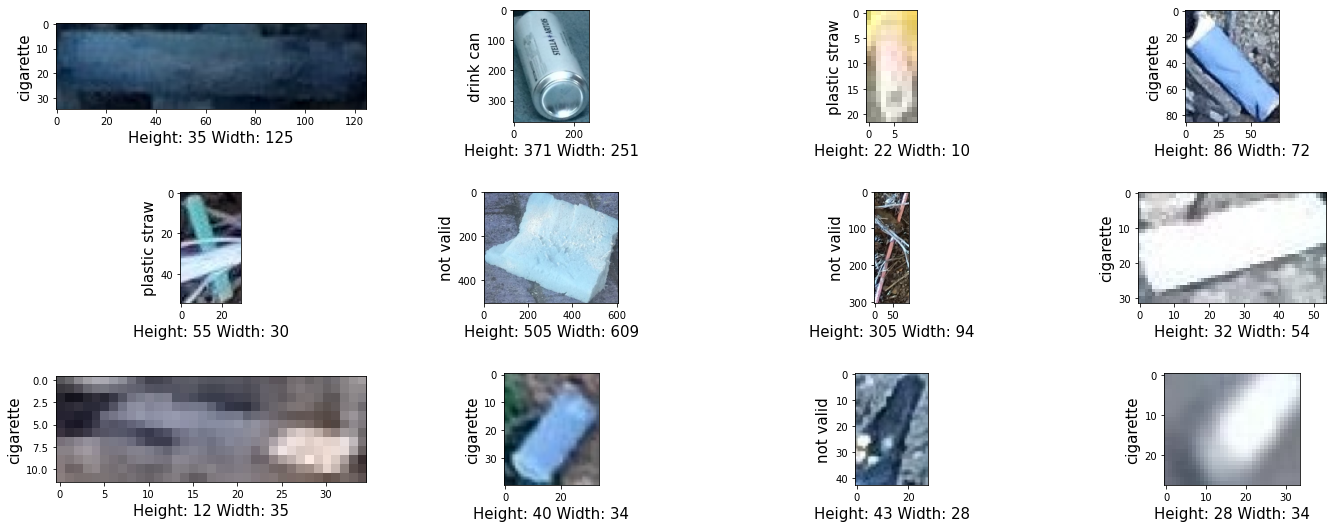

In [17]:
samples = df.sample(n = 12)

img_names = samples.image
categs = samples.category.to_numpy()

show_images(img_names,categs)


## 3. Model Creation

### Model Training

We can create a function in order to fit the model we create, we use as parameter the model, data to fit, etc, so we don't need to replicate all the code to fit and evaluate each of them

In [18]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix


def train(model, X, y, test_size=0.25):
    ## Split between train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = 42)

    print("X train:", X_train.shape, "& X test:", X_test.shape)
    print("y train:", y_train.shape, "& y test:", y_test.shape)
    
    ## Train the model
    model.fit(X_train, y_train)
    
    ## Predict with the model
    pred = model.predict(X_test)
    
    ## Evaluate the model
    print("Model Evaluation:")
    print("Acuracy Score:", accuracy_score(y_test, pred))
    
    cv_score =cross_val_score(model, X, y, cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
#     print("MSError:", mean_squared_error(y_test,pred))
    print("CV Score:", cv_score)
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred))
    
    print("\n")


### Predict Unknown Data

The idea of the machine learning is to be able to extrapolate the learning that the model has gone through and apply it to data that is new for it. 

In order to be able to do that, we'll select some random images from a folder that we know what is the category content inside of it


In [110]:
def predict_unknown_data(model, dataset_file, cat,path='datasets/taco-trash/data/batch_2', n=10):
    ## Import the csv file with the embedded_data
    uk_df = pd.read_csv(dataset_file)
    
    ## Drop all but the images and take n samples (random) from the dataset
    uData = uk_df.drop(['image name', 'size', 'width', 'height'], axis=1)
    samples = uData.sample(n = n)
    X_test = samples.drop(['image'], axis=1)
    
    if not 2048 - X_test.shape[1]== 0:
        last = X_test.shape[1]
        missing = 2048 - last
        for i in range(0,missing):
            X_test[f"n{last+i}"]=0
    
    ## Since all samples are from the same category, we propagate the categories to a np.array of the same n size
    y_test = np.repeat(cat,n)
    
    ## Predict the categorie from the model using the unknown data
    pred = model.predict(X_test)
    
    ## Evaluate the model from the unknown data
    print("Model Evaluation:")
    print("Acuracy Score:", accuracy_score(y_test, pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred))
    print("\n")
    
    show_images(samples.image , y_test, path=path)
    
    return pred
    
    

In [111]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(max_iter = 5, tol = -np.infty, random_state = 42) 
train(model,cData,categories,test_size=0.32)


X train: (1017, 2048) & X test: (480, 2048)
y train: (1017,) & y test: (480,)
(480,) (480,)
Model Evaluation:
Acuracy Score: 0.7833333333333333
CV Score: 0.7761828316610926
Confusion Matrix:
[[191   0   0   3   8   4]
 [  1   6   1   0   4   0]
 [  1   0  66   0  12   1]
 [  1   0   4  16   4   0]
 [ 10   5  22   6  57   6]
 [  4   0   1   0   6  40]]




In [73]:
model = MLPClassifier(random_state=1, max_iter=300)
train(model,cData,categories, test_size=32)


X train: (1465, 2048) & X test: (32, 2048)
y train: (1465,) & y test: (32,)
(32,) (32,)
Model Evaluation:
Acuracy Score: 0.90625
CV Score: 0.8156142697881827
Confusion Matrix:
[[10  0  1  2  0]
 [ 0  2  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0 11  0]
 [ 0  0  0  0  5]]




In [77]:
from sklearn import svm
model = svm.SVC()
train(model,cData,categories, test_size=40)

X train: (1457, 2048) & X test: (40, 2048)
y train: (1457,) & y test: (40,)
(40,) (40,)
Model Evaluation:
Acuracy Score: 0.85
CV Score: 0.8055897435897436
Confusion Matrix:
[[16  0  1  1  0]
 [ 0  3  0  0  0]
 [ 0  0  1  0  0]
 [ 2  0  0 11  0]
 [ 2  0  0  0  3]]




In [81]:
model = svm.SVC(decision_function_shape='ovo')
train(model,cData,categories, test_size=35)

X train: (1462, 2048) & X test: (35, 2048)
y train: (1462,) & y test: (35,)
(35,) (35,)
Model Evaluation:
Acuracy Score: 0.8857142857142857
CV Score: 0.8055897435897436
Confusion Matrix:
[[13  0  1  1  0]
 [ 0  3  0  0  0]
 [ 0  0  1  0  0]
 [ 0  0  0 11  0]
 [ 2  0  0  0  3]]




In [71]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter = 10000)
train(model,cData,categories, test_size=30)


X train: (1467, 2048) & X test: (30, 2048)
y train: (1467,) & y test: (30,)
(30,) (30,)
Model Evaluation:
Acuracy Score: 0.43333333333333335
CV Score: 0.5444526198439241
Confusion Matrix:
[[13  0  0  0  0]
 [ 2  0  0  0  0]
 [ 1  0  0  0  0]
 [ 9  0  0  0  0]
 [ 5  0  0  0  0]]




 <br> <br> <br>

#### Lest try it with some unkown data

Please run the model you want to use before running the next lines.

Model Evaluation:
Acuracy Score: 1.0
Confusion Matrix:
[[10]]




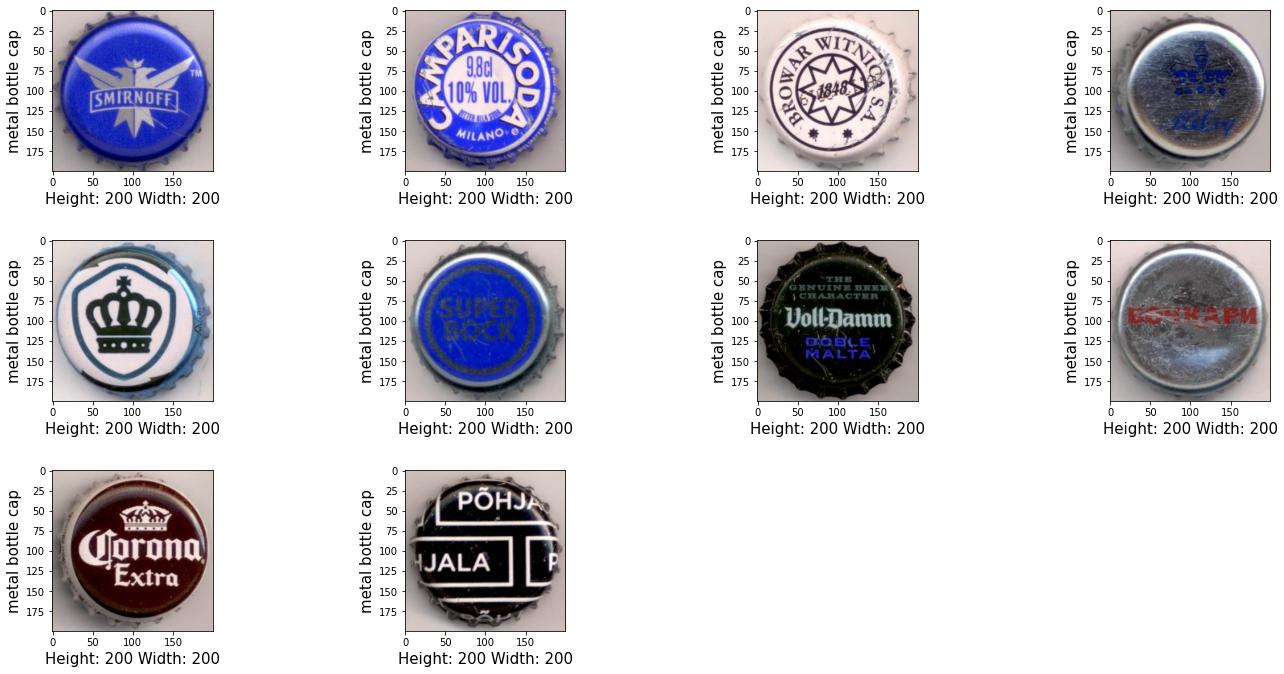

array(['metal bottle cap', 'metal bottle cap', 'metal bottle cap',
       'metal bottle cap', 'metal bottle cap', 'metal bottle cap',
       'metal bottle cap', 'metal bottle cap', 'metal bottle cap',
       'metal bottle cap'], dtype='<U16')

In [112]:
predict_unknown_data(model, "datasets/embedded_caps.csv", "metal bottle cap", "datasets/caps-images")

Model Evaluation:
Acuracy Score: 0.3
Confusion Matrix:
[[3 2 5]
 [0 0 0]
 [0 0 0]]




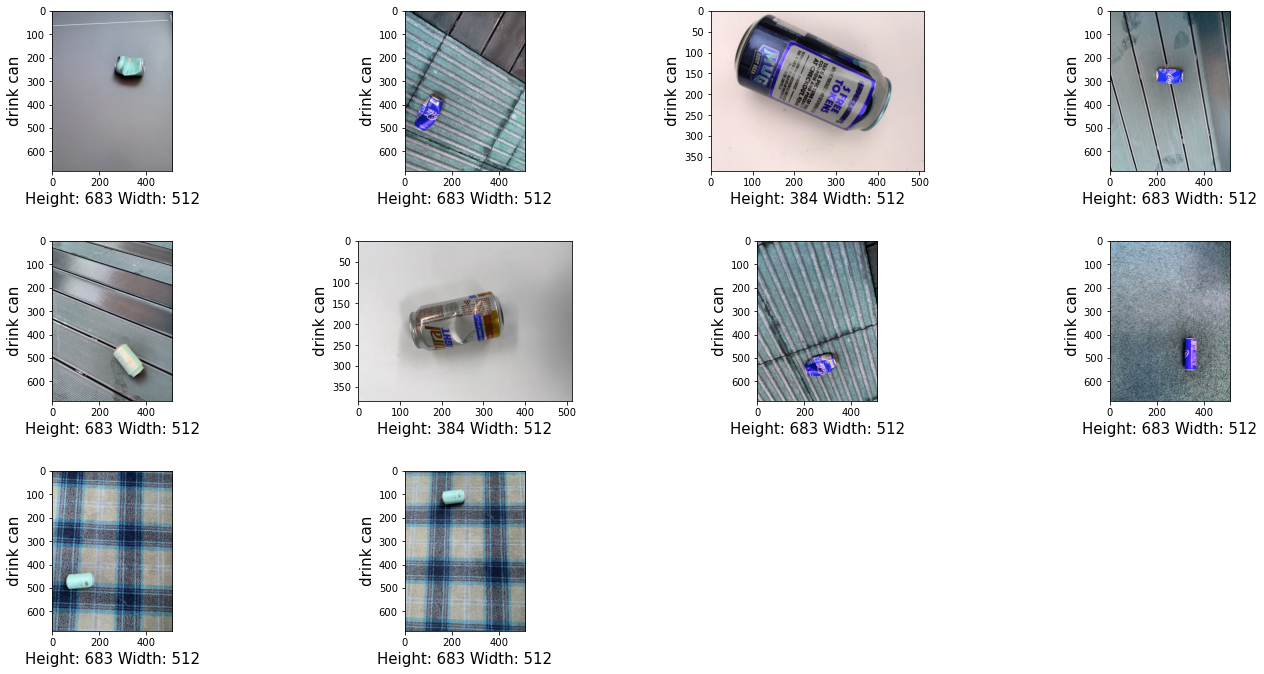

array(['not valid', 'plastic straw', 'drink can', 'plastic straw',
       'not valid', 'drink can', 'plastic straw', 'drink can',
       'plastic straw', 'plastic straw'], dtype='<U16')

In [114]:
predict_unknown_data(model, "datasets/embedded_cans.csv", "drink can", "datasets/AluCan") 